# EEGNet with LSTM

This notebook provides a modified reimplementation of the previously tested CNN-based EEG classifiers:
   - EEGNet by [Lawhern et al](http://iopscience.iop.org/article/10.1088/177/EEGNet_lstm/1-2552/aace8c/meta).
      - Modifications to make it better suited for short-length windows
      - Memory is added after the "feature extraction" layers, the CNN layers, in the form of a LSTM layer

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
No baseline correction was performed and the raw EEG data was used.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.
Some alternatives to this setup were also considered, including one alternative performed for all experiment which uses a long, 1.5 seconds, window.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Same subject, same session: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment (TODO)
- Same subject, same session: EEGNet with bidirectional ConvLSTM2D
   - Results
   - Longer window experiment (TODO)
- Same subject, new session: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment (TODO)
- Same subject, new session: EEGNet with bidirectional ConvLSTM2D
   - Results
   - Longer window experiment (TODO)
- New subject: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment (TODO)
- New subject: EEGNet with bidirectional ConvLSTM2D
   - Results (TODO)
   - Longer window experiment (TODO)

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Same subject, same session: EEGNet bidirectional LSTM 

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 1000 epochs due to the increased training time compared to EEGNet and the fast convergence, knowing it would overfit pretty quickly, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.8021 @ epoch 75                         | 0.5685 @ epoch 170                    | 0.7083                                                | 0.7135                                                 |
| C           | 0.901 @ epoch 301                         | 0.3569 @ epoch 376                    | 0.9062                                                | 0.8958                                                 |
| E           | 0.9058 @ epoch 478                        | 0.3463 @ epoch 400                    | 0.8272                                                | 0.8272                                                 |

With comparable results it is clear that the extension didn't yield improvements nor caused any major issues.
This might suggest that there is just not more information in the data since all results from all these complex models are so comparable for this experiment type.
One noticeable thing is that there is a far greater chance on overfitting, requiring far more extreme dropout.
This is to be expected given the amount of trainable parameters is increased in such an extreme manner.
However, the experiment setup stores both the model with the best validation accuracy and best loss accuracy, so the final obtained models are not really influenced by overfitting behaviour.
The longer windows might aid in reducing this overfitting phenomenon due to the greater amount of data.

The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_samesession/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

#### Longer window experiment

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)
- LSTM size = 128 (from 64)

The performed experiment is equal besides this.
The following results were obtained.

EEGNet:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8802 @ epoch 383                   | 0.3736 @ epoch 632               | 0.7708                                           | 0.7812                                            |
| C           | 0.9479 @ epoch 2290                  | 0.2454 @ epoch 1094              | 0.9531                                           | 0.9375                                            |
| E           | 0.9529 @ epoch 896                   | 0.1631 @ epoch 1224              | 0.9319                                           | 0.9215                                            |

EEGNet with LSTM:

> TODO

Whilst the accuracy improved for the test set significantly for subject C and E, the added complexity and overfitting tendencies is something that should be taken into account when working with longer windows.

The training plots are given below.
B is dark blue, C is light blue and E is green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_samesession/accuracy_long.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_samesession/loss_long.png)

In [5]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 128, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 300, 16)       2400      
                                                                 
 batch_normalization (BatchN  (None, 21, 300, 16)      64        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 300, 64)       1344      
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 300, 64)       256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 1, 300, 64)        0         
                                                        

In [6]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 300, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 16, # number of temporal filters. (default: 8)
        F2 = 32, # number of pointwise filters. (default: 16)
        D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.3, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        LSTM_size = 128, # Amount of units in LSTM layer
        ltsm_dropout = 0.6,
        ltsm_l1 = 0.0005,
        ltsm_l2 = 0.0005
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_long_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model


####################################################
# TRAINING FOR SUBJECT B
####################################################

Shape of all data (epochs, channels, samples): (960, 21, 300)
Shape of train data (epochs, channels, samples): (768, 21, 300)
Shape of test data (epochs, channels, samples): (192, 21, 300)
Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 1.9982 - accuracy: 0.3698
Epoch 1: val_loss improved from inf to 1.95736, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.28646, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 7s 370ms/step - loss: 1.9982 - accuracy: 0.3698 - val_loss: 1.9574 - val_accuracy: 0.2865
Epoch 2/1000
4/5 [=======================>......] - ETA: 0s - loss: 1.9346 - accuracy: 0.3594
Epoch 2: val_


Epoch 16: val_accuracy improved from 0.53125 to 0.57292, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 1s 123ms/step - loss: 1.1521 - accuracy: 0.5260 - val_loss: 1.1311 - val_accuracy: 0.5729
Epoch 17/1000
4/5 [=======================>......] - ETA: 0s - loss: 1.1275 - accuracy: 0.5312
Epoch 17: val_loss improved from 1.13112 to 1.08488, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 17: val_accuracy did not improve from 0.57292
5/5 [==============================] - 1s 125ms/step - loss: 1.1342 - accuracy: 0.5312 - val_loss: 1.0849 - val_accuracy: 0.5625
Epoch 18/1000
4/5 [=======================>......] - ETA: 0s - loss: 1.0863 - accuracy: 0.5605
Epoch 18: val_loss did not improve from 1.08488

Epoch 18: val_accuracy did not improve from 0.57292
5/5 [==============================] - 0s


Epoch 35: val_accuracy did not improve from 0.70833
5/5 [==============================] - 1s 133ms/step - loss: 0.8787 - accuracy: 0.6545 - val_loss: 0.8640 - val_accuracy: 0.6823
Epoch 36/1000
5/5 [==============================] - ETA: 0s - loss: 0.8925 - accuracy: 0.6545
Epoch 36: val_loss improved from 0.86403 to 0.85030, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 36: val_accuracy did not improve from 0.70833
5/5 [==============================] - 1s 188ms/step - loss: 0.8925 - accuracy: 0.6545 - val_loss: 0.8503 - val_accuracy: 0.6771
Epoch 37/1000
5/5 [==============================] - ETA: 0s - loss: 0.8146 - accuracy: 0.7118
Epoch 37: val_loss did not improve from 0.85030

Epoch 37: val_accuracy did not improve from 0.70833
5/5 [==============================] - 1s 226ms/step - loss: 0.8146 - accuracy: 0.7118 - val_loss: 0.8611 - val_accuracy: 0.6771
Epoch 38/1000
4/5 [=====================


Epoch 56: val_accuracy did not improve from 0.79167
5/5 [==============================] - 0s 79ms/step - loss: 0.7082 - accuracy: 0.7344 - val_loss: 0.6844 - val_accuracy: 0.7760
Epoch 57/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.7048 - accuracy: 0.7402
Epoch 57: val_loss improved from 0.66898 to 0.66409, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 57: val_accuracy did not improve from 0.79167
5/5 [==============================] - 0s 94ms/step - loss: 0.7086 - accuracy: 0.7396 - val_loss: 0.6641 - val_accuracy: 0.7656
Epoch 58/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.7141 - accuracy: 0.7344
Epoch 58: val_loss improved from 0.66409 to 0.65065, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 58: val_accuracy did not improve from 0.79167
5/5 [==============================] - 0s 9

Epoch 79/1000
5/5 [==============================] - ETA: 0s - loss: 0.6240 - accuracy: 0.7882
Epoch 79: val_loss did not improve from 0.62410

Epoch 79: val_accuracy did not improve from 0.79688
5/5 [==============================] - 1s 129ms/step - loss: 0.6240 - accuracy: 0.7882 - val_loss: 0.6434 - val_accuracy: 0.7656
Epoch 80/1000
5/5 [==============================] - ETA: 0s - loss: 0.6064 - accuracy: 0.7778
Epoch 80: val_loss improved from 0.62410 to 0.62257, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 80: val_accuracy improved from 0.79688 to 0.80208, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 1s 263ms/step - loss: 0.6064 - accuracy: 0.7778 - val_loss: 0.6226 - val_accuracy: 0.8021
Epoch 81/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6201 - accuracy: 0.7910

Epoch 103/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5541 - accuracy: 0.8105
Epoch 103: val_loss did not improve from 0.61013

Epoch 103: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 77ms/step - loss: 0.5743 - accuracy: 0.8021 - val_loss: 0.6596 - val_accuracy: 0.7656
Epoch 104/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5546 - accuracy: 0.8164
Epoch 104: val_loss did not improve from 0.61013

Epoch 104: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 79ms/step - loss: 0.5458 - accuracy: 0.8212 - val_loss: 0.6312 - val_accuracy: 0.7656
Epoch 105/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5556 - accuracy: 0.8066
Epoch 105: val_loss did not improve from 0.61013

Epoch 105: val_accuracy did not improve from 0.80208
5/5 [==============================] - 0s 78ms/step - loss: 0.5570 - accuracy: 0.8003 - val_loss: 0.6170 - val_accuracy: 0.8021
Epoch 106/1000
4/5 

Epoch 127/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5544 - accuracy: 0.7969
Epoch 127: val_loss did not improve from 0.60327

Epoch 127: val_accuracy did not improve from 0.80729
5/5 [==============================] - 0s 77ms/step - loss: 0.5427 - accuracy: 0.8073 - val_loss: 0.6355 - val_accuracy: 0.7812
Epoch 128/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5361 - accuracy: 0.8027
Epoch 128: val_loss did not improve from 0.60327

Epoch 128: val_accuracy did not improve from 0.80729
5/5 [==============================] - 0s 82ms/step - loss: 0.5381 - accuracy: 0.8038 - val_loss: 0.6381 - val_accuracy: 0.7812
Epoch 129/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5264 - accuracy: 0.8125
Epoch 129: val_loss did not improve from 0.60327

Epoch 129: val_accuracy did not improve from 0.80729
5/5 [==============================] - 0s 80ms/step - loss: 0.5187 - accuracy: 0.8177 - val_loss: 0.6220 - val_accuracy: 0.8073
Epoch 130/1000
4/5 

Epoch 151/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5423 - accuracy: 0.8066
Epoch 151: val_loss did not improve from 0.59254

Epoch 151: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 85ms/step - loss: 0.5287 - accuracy: 0.8160 - val_loss: 0.6343 - val_accuracy: 0.7552
Epoch 152/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4696 - accuracy: 0.8438
Epoch 152: val_loss did not improve from 0.59254

Epoch 152: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 102ms/step - loss: 0.4888 - accuracy: 0.8351 - val_loss: 0.6229 - val_accuracy: 0.7865
Epoch 153/1000
5/5 [==============================] - ETA: 0s - loss: 0.4626 - accuracy: 0.8455
Epoch 153: val_loss did not improve from 0.59254

Epoch 153: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 94ms/step - loss: 0.4626 - accuracy: 0.8455 - val_loss: 0.6295 - val_accuracy: 0.8021
Epoch 154/1000
5/5

4/5 [=======================>......] - ETA: 0s - loss: 0.4761 - accuracy: 0.8574
Epoch 175: val_loss did not improve from 0.58082

Epoch 175: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 78ms/step - loss: 0.4830 - accuracy: 0.8524 - val_loss: 0.6349 - val_accuracy: 0.7812
Epoch 176/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4844 - accuracy: 0.8457
Epoch 176: val_loss did not improve from 0.58082

Epoch 176: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 77ms/step - loss: 0.4837 - accuracy: 0.8420 - val_loss: 0.6068 - val_accuracy: 0.8073
Epoch 177/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4317 - accuracy: 0.8652
Epoch 177: val_loss did not improve from 0.58082

Epoch 177: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 79ms/step - loss: 0.4284 - accuracy: 0.8681 - val_loss: 0.6164 - val_accuracy: 0.7865
Epoch 178/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4359 - accuracy: 0.8633
Epoch 200: val_loss did not improve from 0.58082

Epoch 200: val_accuracy did not improve from 0.81250
5/5 [==============================] - 0s 75ms/step - loss: 0.4330 - accuracy: 0.8594 - val_loss: 0.6393 - val_accuracy: 0.7865
Epoch 201/1000
5/5 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.8507
Epoch 201: val_loss did not improve from 0.58082

Epoch 201: val_accuracy did not improve from 0.81250
5/5 [==============================] - 1s 127ms/step - loss: 0.4565 - accuracy: 0.8507 - val_loss: 0.6476 - val_accuracy: 0.7865
Epoch 202/1000
5/5 [==============================] - ETA: 0s - loss: 0.4170 - accuracy: 0.8628
Epoch 202: val_loss did not improve from 0.58082

Epoch 202: val_accuracy did not improve from 0.81250
5/5 [==============================] - 1s 235ms/step - loss: 0.4170 - accuracy: 0.8628 - val_loss: 0.6468 - val_accuracy: 0.7812
Epoch 203/1000
4/5 [============


Epoch 224: val_accuracy did not improve from 0.81771
5/5 [==============================] - 0s 77ms/step - loss: 0.3932 - accuracy: 0.8750 - val_loss: 0.5988 - val_accuracy: 0.7969
Epoch 225/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4140 - accuracy: 0.8633
Epoch 225: val_loss did not improve from 0.56744

Epoch 225: val_accuracy did not improve from 0.81771
5/5 [==============================] - 0s 79ms/step - loss: 0.4237 - accuracy: 0.8628 - val_loss: 0.6192 - val_accuracy: 0.7969
Epoch 226/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4154 - accuracy: 0.8887
Epoch 226: val_loss did not improve from 0.56744

Epoch 226: val_accuracy did not improve from 0.81771
5/5 [==============================] - 0s 80ms/step - loss: 0.4094 - accuracy: 0.8906 - val_loss: 0.6189 - val_accuracy: 0.7969
Epoch 227/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4086 - accuracy: 0.8828
Epoch 227: val_loss did not improve from 0.56744

Epoch 227: val_acc

4/5 [=======================>......] - ETA: 0s - loss: 0.3773 - accuracy: 0.8633
Epoch 249: val_loss did not improve from 0.56744

Epoch 249: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 79ms/step - loss: 0.3981 - accuracy: 0.8524 - val_loss: 0.5927 - val_accuracy: 0.8021
Epoch 250/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4134 - accuracy: 0.8652
Epoch 250: val_loss did not improve from 0.56744

Epoch 250: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 78ms/step - loss: 0.4103 - accuracy: 0.8646 - val_loss: 0.6220 - val_accuracy: 0.7708
Epoch 251/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4133 - accuracy: 0.8730
Epoch 251: val_loss did not improve from 0.56744

Epoch 251: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 78ms/step - loss: 0.4089 - accuracy: 0.8750 - val_loss: 0.6063 - val_accuracy: 0.7969
Epoch 252/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4435 - accuracy: 0.8574
Epoch 274: val_loss did not improve from 0.56744

Epoch 274: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 77ms/step - loss: 0.4309 - accuracy: 0.8663 - val_loss: 0.6306 - val_accuracy: 0.7500
Epoch 275/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4283 - accuracy: 0.8770
Epoch 275: val_loss did not improve from 0.56744

Epoch 275: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 76ms/step - loss: 0.4252 - accuracy: 0.8767 - val_loss: 0.6229 - val_accuracy: 0.7500
Epoch 276/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4068 - accuracy: 0.8672
Epoch 276: val_loss did not improve from 0.56744

Epoch 276: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 75ms/step - loss: 0.4148 - accuracy: 0.8628 - val_loss: 0.6032 - val_accuracy: 0.7500
Epoch 277/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3827 - accuracy: 0.8945
Epoch 299: val_loss did not improve from 0.56744

Epoch 299: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 78ms/step - loss: 0.3890 - accuracy: 0.8924 - val_loss: 0.6405 - val_accuracy: 0.7812
Epoch 300/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3352 - accuracy: 0.9043
Epoch 300: val_loss did not improve from 0.56744

Epoch 300: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 78ms/step - loss: 0.3329 - accuracy: 0.9062 - val_loss: 0.6246 - val_accuracy: 0.8021
Epoch 301/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3534 - accuracy: 0.9102
Epoch 301: val_loss did not improve from 0.56744

Epoch 301: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 79ms/step - loss: 0.3478 - accuracy: 0.9097 - val_loss: 0.6381 - val_accuracy: 0.7656
Epoch 302/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.4123 - accuracy: 0.8789
Epoch 324: val_loss did not improve from 0.56744

Epoch 324: val_accuracy did not improve from 0.82812
5/5 [==============================] - 1s 96ms/step - loss: 0.4146 - accuracy: 0.8785 - val_loss: 0.6218 - val_accuracy: 0.8021
Epoch 325/1000
5/5 [==============================] - ETA: 0s - loss: 0.3617 - accuracy: 0.9062
Epoch 325: val_loss did not improve from 0.56744

Epoch 325: val_accuracy did not improve from 0.82812
5/5 [==============================] - 1s 143ms/step - loss: 0.3617 - accuracy: 0.9062 - val_loss: 0.6088 - val_accuracy: 0.8125
Epoch 326/1000
5/5 [==============================] - ETA: 0s - loss: 0.3658 - accuracy: 0.8976
Epoch 326: val_loss did not improve from 0.56744

Epoch 326: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 101ms/step - loss: 0.3658 - accuracy: 0.8976 - val_loss: 0.5984 - val_accuracy: 0.7917
Epoch 327/1000
5/5 [============

4/5 [=======================>......] - ETA: 0s - loss: 0.3468 - accuracy: 0.9004
Epoch 349: val_loss did not improve from 0.56744

Epoch 349: val_accuracy did not improve from 0.82812
5/5 [==============================] - 0s 80ms/step - loss: 0.3372 - accuracy: 0.9080 - val_loss: 0.5985 - val_accuracy: 0.8073
Epoch 350/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3601 - accuracy: 0.9043
Epoch 350: val_loss did not improve from 0.56744

Epoch 350: val_accuracy improved from 0.82812 to 0.83854, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 94ms/step - loss: 0.3565 - accuracy: 0.9045 - val_loss: 0.5837 - val_accuracy: 0.8385
Epoch 351/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3385 - accuracy: 0.9043
Epoch 351: val_loss did not improve from 0.56744

Epoch 351: val_accuracy did not improve from 0.83854
5/5 [=============================


Epoch 373: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.3115 - accuracy: 0.9219 - val_loss: 0.5863 - val_accuracy: 0.8125
Epoch 374/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3279 - accuracy: 0.9082
Epoch 374: val_loss did not improve from 0.55317

Epoch 374: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.3141 - accuracy: 0.9167 - val_loss: 0.5942 - val_accuracy: 0.7917
Epoch 375/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3331 - accuracy: 0.9180
Epoch 375: val_loss did not improve from 0.55317

Epoch 375: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.3323 - accuracy: 0.9184 - val_loss: 0.6048 - val_accuracy: 0.7760
Epoch 376/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3053 - accuracy: 0.9297
Epoch 376: val_loss did not improve from 0.55317

Epoch 376: val_acc

5/5 [==============================] - 0s 83ms/step - loss: 0.2969 - accuracy: 0.9271 - val_loss: 0.6214 - val_accuracy: 0.7865
Epoch 399/1000
5/5 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.9288
Epoch 399: val_loss did not improve from 0.55317

Epoch 399: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 90ms/step - loss: 0.2953 - accuracy: 0.9288 - val_loss: 0.6210 - val_accuracy: 0.7812
Epoch 400/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2976 - accuracy: 0.9160
Epoch 400: val_loss did not improve from 0.55317

Epoch 400: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 82ms/step - loss: 0.2916 - accuracy: 0.9236 - val_loss: 0.6161 - val_accuracy: 0.7865
Epoch 401/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3154 - accuracy: 0.9258
Epoch 401: val_loss did not improve from 0.55317

Epoch 401: val_accuracy did not improve from 0.83854
5/5 [==============

Epoch 424/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2983 - accuracy: 0.9375
Epoch 424: val_loss did not improve from 0.55317

Epoch 424: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.3042 - accuracy: 0.9340 - val_loss: 0.6441 - val_accuracy: 0.7656
Epoch 425/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3046 - accuracy: 0.9160
Epoch 425: val_loss did not improve from 0.55317

Epoch 425: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.3062 - accuracy: 0.9167 - val_loss: 0.6185 - val_accuracy: 0.7917
Epoch 426/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2904 - accuracy: 0.9316
Epoch 426: val_loss did not improve from 0.55317

Epoch 426: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 75ms/step - loss: 0.2853 - accuracy: 0.9358 - val_loss: 0.6207 - val_accuracy: 0.7917
Epoch 427/1000
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.3306 - accuracy: 0.9062
Epoch 449: val_loss did not improve from 0.55317

Epoch 449: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.3207 - accuracy: 0.9132 - val_loss: 0.6740 - val_accuracy: 0.7500
Epoch 450/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3445 - accuracy: 0.9082
Epoch 450: val_loss did not improve from 0.55317

Epoch 450: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 80ms/step - loss: 0.3396 - accuracy: 0.9115 - val_loss: 0.6489 - val_accuracy: 0.7552
Epoch 451/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2958 - accuracy: 0.9277
Epoch 451: val_loss did not improve from 0.55317

Epoch 451: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.2934 - accuracy: 0.9306 - val_loss: 0.6324 - val_accuracy: 0.7604
Epoch 452/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2878 - accuracy: 0.9316
Epoch 474: val_loss did not improve from 0.55317

Epoch 474: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.2869 - accuracy: 0.9306 - val_loss: 0.6395 - val_accuracy: 0.7917
Epoch 475/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3005 - accuracy: 0.9180
Epoch 475: val_loss did not improve from 0.55317

Epoch 475: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.3222 - accuracy: 0.9062 - val_loss: 0.6460 - val_accuracy: 0.7865
Epoch 476/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2910 - accuracy: 0.9355
Epoch 476: val_loss did not improve from 0.55317

Epoch 476: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.3009 - accuracy: 0.9340 - val_loss: 0.6594 - val_accuracy: 0.7917
Epoch 477/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2702 - accuracy: 0.9492
Epoch 499: val_loss did not improve from 0.55317

Epoch 499: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.2778 - accuracy: 0.9444 - val_loss: 0.6815 - val_accuracy: 0.7760
Epoch 500/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2952 - accuracy: 0.9434
Epoch 500: val_loss did not improve from 0.55317

Epoch 500: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.2940 - accuracy: 0.9392 - val_loss: 0.6941 - val_accuracy: 0.7656
Epoch 501/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2882 - accuracy: 0.9375
Epoch 501: val_loss did not improve from 0.55317

Epoch 501: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 80ms/step - loss: 0.2833 - accuracy: 0.9392 - val_loss: 0.7037 - val_accuracy: 0.7760
Epoch 502/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2830 - accuracy: 0.9199
Epoch 524: val_loss did not improve from 0.55317

Epoch 524: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.2789 - accuracy: 0.9236 - val_loss: 0.6326 - val_accuracy: 0.7865
Epoch 525/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2540 - accuracy: 0.9434
Epoch 525: val_loss did not improve from 0.55317

Epoch 525: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.2605 - accuracy: 0.9427 - val_loss: 0.6082 - val_accuracy: 0.8021
Epoch 526/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2362 - accuracy: 0.9590
Epoch 526: val_loss did not improve from 0.55317

Epoch 526: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 80ms/step - loss: 0.2380 - accuracy: 0.9583 - val_loss: 0.6212 - val_accuracy: 0.7917
Epoch 527/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3099 - accuracy: 0.9141
Epoch 549: val_loss did not improve from 0.55317

Epoch 549: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.3016 - accuracy: 0.9184 - val_loss: 0.6950 - val_accuracy: 0.7396
Epoch 550/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3104 - accuracy: 0.9316
Epoch 550: val_loss did not improve from 0.55317

Epoch 550: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 80ms/step - loss: 0.3162 - accuracy: 0.9288 - val_loss: 0.7279 - val_accuracy: 0.7240
Epoch 551/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2752 - accuracy: 0.9473
Epoch 551: val_loss did not improve from 0.55317

Epoch 551: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.2865 - accuracy: 0.9427 - val_loss: 0.7288 - val_accuracy: 0.7448
Epoch 552/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2438 - accuracy: 0.9453
Epoch 574: val_loss did not improve from 0.55317

Epoch 574: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.2437 - accuracy: 0.9444 - val_loss: 0.6591 - val_accuracy: 0.7969
Epoch 575/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2361 - accuracy: 0.9473
Epoch 575: val_loss did not improve from 0.55317

Epoch 575: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.2365 - accuracy: 0.9479 - val_loss: 0.6788 - val_accuracy: 0.7917
Epoch 576/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2429 - accuracy: 0.9492
Epoch 576: val_loss did not improve from 0.55317

Epoch 576: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 80ms/step - loss: 0.2495 - accuracy: 0.9410 - val_loss: 0.6870 - val_accuracy: 0.7760
Epoch 577/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2204 - accuracy: 0.9590
Epoch 599: val_loss did not improve from 0.55317

Epoch 599: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.2170 - accuracy: 0.9618 - val_loss: 0.6919 - val_accuracy: 0.7812
Epoch 600/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2367 - accuracy: 0.9609
Epoch 600: val_loss did not improve from 0.55317

Epoch 600: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.2353 - accuracy: 0.9601 - val_loss: 0.6987 - val_accuracy: 0.7656
Epoch 601/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2439 - accuracy: 0.9414
Epoch 601: val_loss did not improve from 0.55317

Epoch 601: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.2456 - accuracy: 0.9410 - val_loss: 0.6612 - val_accuracy: 0.8021
Epoch 602/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2643 - accuracy: 0.9316
Epoch 624: val_loss did not improve from 0.55317

Epoch 624: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.2586 - accuracy: 0.9375 - val_loss: 0.6741 - val_accuracy: 0.7865
Epoch 625/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2798 - accuracy: 0.9395
Epoch 625: val_loss did not improve from 0.55317

Epoch 625: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.2783 - accuracy: 0.9375 - val_loss: 0.6782 - val_accuracy: 0.7917
Epoch 626/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2451 - accuracy: 0.9473
Epoch 626: val_loss did not improve from 0.55317

Epoch 626: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.2398 - accuracy: 0.9497 - val_loss: 0.6524 - val_accuracy: 0.7917
Epoch 627/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2222 - accuracy: 0.9512
Epoch 649: val_loss did not improve from 0.55317

Epoch 649: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 81ms/step - loss: 0.2294 - accuracy: 0.9497 - val_loss: 0.7159 - val_accuracy: 0.7552
Epoch 650/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2928 - accuracy: 0.9336
Epoch 650: val_loss did not improve from 0.55317

Epoch 650: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.3006 - accuracy: 0.9288 - val_loss: 0.7300 - val_accuracy: 0.7708
Epoch 651/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3269 - accuracy: 0.9180
Epoch 651: val_loss did not improve from 0.55317

Epoch 651: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.3317 - accuracy: 0.9132 - val_loss: 0.7284 - val_accuracy: 0.7656
Epoch 652/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2833 - accuracy: 0.9414
Epoch 674: val_loss did not improve from 0.55317

Epoch 674: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.2888 - accuracy: 0.9392 - val_loss: 0.6677 - val_accuracy: 0.7812
Epoch 675/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2508 - accuracy: 0.9531
Epoch 675: val_loss did not improve from 0.55317

Epoch 675: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 75ms/step - loss: 0.2552 - accuracy: 0.9531 - val_loss: 0.6365 - val_accuracy: 0.7917
Epoch 676/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2466 - accuracy: 0.9453
Epoch 676: val_loss did not improve from 0.55317

Epoch 676: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.2483 - accuracy: 0.9462 - val_loss: 0.6451 - val_accuracy: 0.7865
Epoch 677/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2251 - accuracy: 0.9531
Epoch 699: val_loss did not improve from 0.55317

Epoch 699: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 80ms/step - loss: 0.2175 - accuracy: 0.9583 - val_loss: 0.6524 - val_accuracy: 0.8073
Epoch 700/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2237 - accuracy: 0.9590
Epoch 700: val_loss did not improve from 0.55317

Epoch 700: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.2186 - accuracy: 0.9618 - val_loss: 0.6264 - val_accuracy: 0.8177
Epoch 701/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2203 - accuracy: 0.9590
Epoch 701: val_loss did not improve from 0.55317

Epoch 701: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.2223 - accuracy: 0.9601 - val_loss: 0.6349 - val_accuracy: 0.8229
Epoch 702/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2654 - accuracy: 0.9434
Epoch 724: val_loss did not improve from 0.55317

Epoch 724: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.2652 - accuracy: 0.9462 - val_loss: 0.6916 - val_accuracy: 0.7760
Epoch 725/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2542 - accuracy: 0.9492
Epoch 725: val_loss did not improve from 0.55317

Epoch 725: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.2452 - accuracy: 0.9531 - val_loss: 0.6845 - val_accuracy: 0.7865
Epoch 726/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2790 - accuracy: 0.9375
Epoch 726: val_loss did not improve from 0.55317

Epoch 726: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.2680 - accuracy: 0.9444 - val_loss: 0.6412 - val_accuracy: 0.7969
Epoch 727/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2079 - accuracy: 0.9707
Epoch 749: val_loss did not improve from 0.55317

Epoch 749: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.2083 - accuracy: 0.9688 - val_loss: 0.7038 - val_accuracy: 0.7812
Epoch 750/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2340 - accuracy: 0.9609
Epoch 750: val_loss did not improve from 0.55317

Epoch 750: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.2280 - accuracy: 0.9635 - val_loss: 0.6829 - val_accuracy: 0.8021
Epoch 751/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1956 - accuracy: 0.9648
Epoch 751: val_loss did not improve from 0.55317

Epoch 751: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.1968 - accuracy: 0.9670 - val_loss: 0.7090 - val_accuracy: 0.7760
Epoch 752/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2327 - accuracy: 0.9473
Epoch 774: val_loss did not improve from 0.55317

Epoch 774: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.2305 - accuracy: 0.9497 - val_loss: 0.6498 - val_accuracy: 0.7969
Epoch 775/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2167 - accuracy: 0.9570
Epoch 775: val_loss did not improve from 0.55317

Epoch 775: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.2240 - accuracy: 0.9514 - val_loss: 0.6440 - val_accuracy: 0.8229
Epoch 776/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2367 - accuracy: 0.9570
Epoch 776: val_loss did not improve from 0.55317

Epoch 776: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.2313 - accuracy: 0.9601 - val_loss: 0.6458 - val_accuracy: 0.7969
Epoch 777/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1788 - accuracy: 0.9746
Epoch 799: val_loss did not improve from 0.55317

Epoch 799: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.1735 - accuracy: 0.9757 - val_loss: 0.6848 - val_accuracy: 0.7812
Epoch 800/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1784 - accuracy: 0.9668
Epoch 800: val_loss did not improve from 0.55317

Epoch 800: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.1789 - accuracy: 0.9653 - val_loss: 0.6712 - val_accuracy: 0.8021
Epoch 801/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2089 - accuracy: 0.9590
Epoch 801: val_loss did not improve from 0.55317

Epoch 801: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 80ms/step - loss: 0.2059 - accuracy: 0.9601 - val_loss: 0.6806 - val_accuracy: 0.7917
Epoch 802/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1730 - accuracy: 0.9668
Epoch 824: val_loss did not improve from 0.55317

Epoch 824: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.1730 - accuracy: 0.9653 - val_loss: 0.6837 - val_accuracy: 0.7760
Epoch 825/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1748 - accuracy: 0.9688
Epoch 825: val_loss did not improve from 0.55317

Epoch 825: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.1832 - accuracy: 0.9653 - val_loss: 0.6619 - val_accuracy: 0.7917
Epoch 826/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1786 - accuracy: 0.9688
Epoch 826: val_loss did not improve from 0.55317

Epoch 826: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.1757 - accuracy: 0.9722 - val_loss: 0.6660 - val_accuracy: 0.8073
Epoch 827/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1900 - accuracy: 0.9707
Epoch 849: val_loss did not improve from 0.55317

Epoch 849: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 76ms/step - loss: 0.1926 - accuracy: 0.9688 - val_loss: 0.6629 - val_accuracy: 0.8021
Epoch 850/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2052 - accuracy: 0.9668
Epoch 850: val_loss did not improve from 0.55317

Epoch 850: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.2071 - accuracy: 0.9653 - val_loss: 0.6814 - val_accuracy: 0.7865
Epoch 851/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1960 - accuracy: 0.9707
Epoch 851: val_loss did not improve from 0.55317

Epoch 851: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.1919 - accuracy: 0.9740 - val_loss: 0.7167 - val_accuracy: 0.7760
Epoch 852/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2174 - accuracy: 0.9590
Epoch 874: val_loss did not improve from 0.55317

Epoch 874: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 76ms/step - loss: 0.2230 - accuracy: 0.9531 - val_loss: 0.7390 - val_accuracy: 0.7656
Epoch 875/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1993 - accuracy: 0.9727
Epoch 875: val_loss did not improve from 0.55317

Epoch 875: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.2035 - accuracy: 0.9688 - val_loss: 0.7041 - val_accuracy: 0.7708
Epoch 876/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2177 - accuracy: 0.9746
Epoch 876: val_loss did not improve from 0.55317

Epoch 876: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.2182 - accuracy: 0.9740 - val_loss: 0.6918 - val_accuracy: 0.7708
Epoch 877/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1860 - accuracy: 0.9785
Epoch 899: val_loss did not improve from 0.55317

Epoch 899: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 80ms/step - loss: 0.1914 - accuracy: 0.9774 - val_loss: 0.7386 - val_accuracy: 0.7552
Epoch 900/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1785 - accuracy: 0.9844
Epoch 900: val_loss did not improve from 0.55317

Epoch 900: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.1808 - accuracy: 0.9809 - val_loss: 0.7291 - val_accuracy: 0.7760
Epoch 901/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1865 - accuracy: 0.9707
Epoch 901: val_loss did not improve from 0.55317

Epoch 901: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.1832 - accuracy: 0.9722 - val_loss: 0.7204 - val_accuracy: 0.7760
Epoch 902/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2385 - accuracy: 0.9570
Epoch 924: val_loss did not improve from 0.55317

Epoch 924: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 78ms/step - loss: 0.2353 - accuracy: 0.9583 - val_loss: 0.7089 - val_accuracy: 0.7656
Epoch 925/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2111 - accuracy: 0.9727
Epoch 925: val_loss did not improve from 0.55317

Epoch 925: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 76ms/step - loss: 0.2137 - accuracy: 0.9722 - val_loss: 0.6993 - val_accuracy: 0.7708
Epoch 926/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2058 - accuracy: 0.9648
Epoch 926: val_loss did not improve from 0.55317

Epoch 926: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 76ms/step - loss: 0.2015 - accuracy: 0.9653 - val_loss: 0.6860 - val_accuracy: 0.7812
Epoch 927/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1791 - accuracy: 0.9824
Epoch 949: val_loss did not improve from 0.55317

Epoch 949: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.1831 - accuracy: 0.9792 - val_loss: 0.6890 - val_accuracy: 0.7760
Epoch 950/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1817 - accuracy: 0.9688
Epoch 950: val_loss did not improve from 0.55317

Epoch 950: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.1831 - accuracy: 0.9688 - val_loss: 0.7070 - val_accuracy: 0.7604
Epoch 951/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1922 - accuracy: 0.9668
Epoch 951: val_loss did not improve from 0.55317

Epoch 951: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 75ms/step - loss: 0.1898 - accuracy: 0.9670 - val_loss: 0.6942 - val_accuracy: 0.7708
Epoch 952/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1514 - accuracy: 0.9844
Epoch 974: val_loss did not improve from 0.55317

Epoch 974: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 76ms/step - loss: 0.1630 - accuracy: 0.9809 - val_loss: 0.6667 - val_accuracy: 0.7969
Epoch 975/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1738 - accuracy: 0.9727
Epoch 975: val_loss did not improve from 0.55317

Epoch 975: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 76ms/step - loss: 0.1763 - accuracy: 0.9722 - val_loss: 0.6883 - val_accuracy: 0.7917
Epoch 976/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1610 - accuracy: 0.9766
Epoch 976: val_loss did not improve from 0.55317

Epoch 976: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.1716 - accuracy: 0.9722 - val_loss: 0.6936 - val_accuracy: 0.7708
Epoch 977/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1625 - accuracy: 0.9824
Epoch 999: val_loss did not improve from 0.55317

Epoch 999: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.1624 - accuracy: 0.9809 - val_loss: 0.6855 - val_accuracy: 0.7917
Epoch 1000/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1656 - accuracy: 0.9785
Epoch 1000: val_loss did not improve from 0.55317

Epoch 1000: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 77ms/step - loss: 0.1692 - accuracy: 0.9757 - val_loss: 0.6933 - val_accuracy: 0.7917

####################################################
# TRAINING FOR SUBJECT C
####################################################

Shape of all data (epochs, channels, samples): (959, 21, 300)
Shape of train data (epochs, channels, samples): (767, 21, 300)
Shape of test data (epochs, channels, samples): (192, 21, 300)
Epoch 1/1000
5/5 [==================


Epoch 16: val_accuracy improved from 0.59375 to 0.64062, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectC\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 105ms/step - loss: 0.9831 - accuracy: 0.6609 - val_loss: 1.0517 - val_accuracy: 0.6406
Epoch 17/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.9742 - accuracy: 0.6543
Epoch 17: val_loss improved from 1.05167 to 1.02883, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 17: val_accuracy did not improve from 0.64062
5/5 [==============================] - 0s 90ms/step - loss: 0.9692 - accuracy: 0.6539 - val_loss: 1.0288 - val_accuracy: 0.6406
Epoch 18/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.9212 - accuracy: 0.6641
Epoch 18: val_loss improved from 1.02883 to 1.02879, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectC\trai

4/5 [=======================>......] - ETA: 0s - loss: 0.6384 - accuracy: 0.7969
Epoch 34: val_loss improved from 0.70577 to 0.70128, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 34: val_accuracy did not improve from 0.78125
5/5 [==============================] - 0s 91ms/step - loss: 0.6422 - accuracy: 0.7948 - val_loss: 0.7013 - val_accuracy: 0.7292
Epoch 35/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6540 - accuracy: 0.7617
Epoch 35: val_loss did not improve from 0.70128

Epoch 35: val_accuracy did not improve from 0.78125
5/5 [==============================] - 0s 77ms/step - loss: 0.6523 - accuracy: 0.7670 - val_loss: 0.7574 - val_accuracy: 0.7344
Epoch 36/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6595 - accuracy: 0.7832
Epoch 36: val_loss did not improve from 0.70128

Epoch 36: val_accuracy did not improve from 0.78125
5/5 [==============================] - 0s 

4/5 [=======================>......] - ETA: 0s - loss: 0.4772 - accuracy: 0.8477
Epoch 54: val_loss improved from 0.55033 to 0.53294, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 54: val_accuracy improved from 0.83333 to 0.83854, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectC\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 105ms/step - loss: 0.4895 - accuracy: 0.8383 - val_loss: 0.5329 - val_accuracy: 0.8385
Epoch 55/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4987 - accuracy: 0.8477
Epoch 55: val_loss did not improve from 0.53294

Epoch 55: val_accuracy did not improve from 0.83854
5/5 [==============================] - 0s 79ms/step - loss: 0.4929 - accuracy: 0.8504 - val_loss: 0.5603 - val_accuracy: 0.7969
Epoch 56/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4793 - accuracy: 0.8398
Epoch 56: val_

Epoch 77/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4126 - accuracy: 0.8730
Epoch 77: val_loss did not improve from 0.51453

Epoch 77: val_accuracy did not improve from 0.84375
5/5 [==============================] - 0s 80ms/step - loss: 0.4139 - accuracy: 0.8765 - val_loss: 0.5975 - val_accuracy: 0.7917
Epoch 78/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4419 - accuracy: 0.8613
Epoch 78: val_loss did not improve from 0.51453

Epoch 78: val_accuracy did not improve from 0.84375
5/5 [==============================] - 0s 80ms/step - loss: 0.4370 - accuracy: 0.8661 - val_loss: 0.5327 - val_accuracy: 0.8125
Epoch 79/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4143 - accuracy: 0.8770
Epoch 79: val_loss improved from 0.51453 to 0.50417, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 79: val_accuracy did not improve from 0.84375
5/5 [=======================

Epoch 100/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3476 - accuracy: 0.9023
Epoch 100: val_loss did not improve from 0.46739

Epoch 100: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 77ms/step - loss: 0.3452 - accuracy: 0.9043 - val_loss: 0.4736 - val_accuracy: 0.8333
Epoch 101/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3640 - accuracy: 0.8906
Epoch 101: val_loss did not improve from 0.46739

Epoch 101: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 79ms/step - loss: 0.3542 - accuracy: 0.8957 - val_loss: 0.4777 - val_accuracy: 0.8125
Epoch 102/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3448 - accuracy: 0.9082
Epoch 102: val_loss did not improve from 0.46739

Epoch 102: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 78ms/step - loss: 0.3561 - accuracy: 0.9009 - val_loss: 0.5133 - val_accuracy: 0.8021
Epoch 103/1000
4/5 


Epoch 124: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 93ms/step - loss: 0.3397 - accuracy: 0.9043 - val_loss: 0.4560 - val_accuracy: 0.8333
Epoch 125/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3372 - accuracy: 0.9004
Epoch 125: val_loss improved from 0.45600 to 0.45546, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 125: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 93ms/step - loss: 0.3317 - accuracy: 0.9061 - val_loss: 0.4555 - val_accuracy: 0.8542
Epoch 126/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3140 - accuracy: 0.9102
Epoch 126: val_loss did not improve from 0.45546

Epoch 126: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 78ms/step - loss: 0.3087 - accuracy: 0.9113 - val_loss: 0.4592 - val_accuracy: 0.8438
Epoch 127/1000
4/5 [================

Epoch 147/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3360 - accuracy: 0.8984
Epoch 147: val_loss did not improve from 0.41627

Epoch 147: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 78ms/step - loss: 0.3316 - accuracy: 0.8991 - val_loss: 0.4484 - val_accuracy: 0.8490
Epoch 148/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3247 - accuracy: 0.9141
Epoch 148: val_loss did not improve from 0.41627

Epoch 148: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 81ms/step - loss: 0.3186 - accuracy: 0.9130 - val_loss: 0.4294 - val_accuracy: 0.8594
Epoch 149/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3254 - accuracy: 0.8984
Epoch 149: val_loss did not improve from 0.41627

Epoch 149: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 77ms/step - loss: 0.3205 - accuracy: 0.8974 - val_loss: 0.4303 - val_accuracy: 0.8542
Epoch 150/1000
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.2919 - accuracy: 0.9199
Epoch 172: val_loss did not improve from 0.41627

Epoch 172: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 77ms/step - loss: 0.2840 - accuracy: 0.9235 - val_loss: 0.4328 - val_accuracy: 0.8438
Epoch 173/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2796 - accuracy: 0.9199
Epoch 173: val_loss did not improve from 0.41627

Epoch 173: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 78ms/step - loss: 0.2831 - accuracy: 0.9183 - val_loss: 0.4639 - val_accuracy: 0.8333
Epoch 174/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2768 - accuracy: 0.9219
Epoch 174: val_loss did not improve from 0.41627

Epoch 174: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 77ms/step - loss: 0.2726 - accuracy: 0.9252 - val_loss: 0.4372 - val_accuracy: 0.8646
Epoch 175/1000
4/5 [==============


Epoch 196: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 78ms/step - loss: 0.2782 - accuracy: 0.9252 - val_loss: 0.4388 - val_accuracy: 0.8125
Epoch 197/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2777 - accuracy: 0.9297
Epoch 197: val_loss did not improve from 0.41035

Epoch 197: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 77ms/step - loss: 0.2686 - accuracy: 0.9322 - val_loss: 0.4940 - val_accuracy: 0.8281
Epoch 198/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2835 - accuracy: 0.9199
Epoch 198: val_loss did not improve from 0.41035

Epoch 198: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 79ms/step - loss: 0.2778 - accuracy: 0.9235 - val_loss: 0.4779 - val_accuracy: 0.8125
Epoch 199/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2608 - accuracy: 0.9414
Epoch 199: val_loss did not improve from 0.41035

Epoch 199: val_acc

5/5 [==============================] - 0s 79ms/step - loss: 0.2796 - accuracy: 0.9165 - val_loss: 0.4455 - val_accuracy: 0.8229
Epoch 222/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2537 - accuracy: 0.9277
Epoch 222: val_loss did not improve from 0.41035

Epoch 222: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 78ms/step - loss: 0.2607 - accuracy: 0.9252 - val_loss: 0.4485 - val_accuracy: 0.8542
Epoch 223/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2589 - accuracy: 0.9238
Epoch 223: val_loss did not improve from 0.41035

Epoch 223: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 79ms/step - loss: 0.2578 - accuracy: 0.9270 - val_loss: 0.4590 - val_accuracy: 0.8646
Epoch 224/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2600 - accuracy: 0.9238
Epoch 224: val_loss did not improve from 0.41035

Epoch 224: val_accuracy did not improve from 0.86979
5/5 [==============

5/5 [==============================] - 0s 80ms/step - loss: 0.2546 - accuracy: 0.9357 - val_loss: 0.4357 - val_accuracy: 0.8385
Epoch 246/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2398 - accuracy: 0.9355
Epoch 246: val_loss did not improve from 0.39848

Epoch 246: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 75ms/step - loss: 0.2394 - accuracy: 0.9391 - val_loss: 0.4368 - val_accuracy: 0.8333
Epoch 247/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2682 - accuracy: 0.9277
Epoch 247: val_loss did not improve from 0.39848

Epoch 247: val_accuracy did not improve from 0.86979
5/5 [==============================] - 0s 75ms/step - loss: 0.2720 - accuracy: 0.9235 - val_loss: 0.4133 - val_accuracy: 0.8490
Epoch 248/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2370 - accuracy: 0.9434
Epoch 248: val_loss did not improve from 0.39848

Epoch 248: val_accuracy did not improve from 0.86979
5/5 [==============

Epoch 270/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2229 - accuracy: 0.9512
Epoch 270: val_loss did not improve from 0.39742

Epoch 270: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 78ms/step - loss: 0.2294 - accuracy: 0.9496 - val_loss: 0.4494 - val_accuracy: 0.8490
Epoch 271/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2368 - accuracy: 0.9375
Epoch 271: val_loss did not improve from 0.39742

Epoch 271: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 80ms/step - loss: 0.2365 - accuracy: 0.9391 - val_loss: 0.4801 - val_accuracy: 0.8281
Epoch 272/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2237 - accuracy: 0.9375
Epoch 272: val_loss did not improve from 0.39742

Epoch 272: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 77ms/step - loss: 0.2287 - accuracy: 0.9357 - val_loss: 0.4641 - val_accuracy: 0.8385
Epoch 273/1000
4/5 

Epoch 295/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2426 - accuracy: 0.9473
Epoch 295: val_loss did not improve from 0.39642

Epoch 295: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 77ms/step - loss: 0.2419 - accuracy: 0.9443 - val_loss: 0.4728 - val_accuracy: 0.8073
Epoch 296/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2539 - accuracy: 0.9277
Epoch 296: val_loss did not improve from 0.39642

Epoch 296: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 79ms/step - loss: 0.2466 - accuracy: 0.9322 - val_loss: 0.4578 - val_accuracy: 0.8177
Epoch 297/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2337 - accuracy: 0.9277
Epoch 297: val_loss did not improve from 0.39642

Epoch 297: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 77ms/step - loss: 0.2397 - accuracy: 0.9252 - val_loss: 0.4799 - val_accuracy: 0.8177
Epoch 298/1000
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.2359 - accuracy: 0.9336
Epoch 320: val_loss did not improve from 0.39642

Epoch 320: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 80ms/step - loss: 0.2383 - accuracy: 0.9322 - val_loss: 0.4924 - val_accuracy: 0.8229
Epoch 321/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2800 - accuracy: 0.9121
Epoch 321: val_loss did not improve from 0.39642

Epoch 321: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 77ms/step - loss: 0.2721 - accuracy: 0.9183 - val_loss: 0.4997 - val_accuracy: 0.8177
Epoch 322/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2323 - accuracy: 0.9355
Epoch 322: val_loss did not improve from 0.39642

Epoch 322: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 78ms/step - loss: 0.2262 - accuracy: 0.9374 - val_loss: 0.4959 - val_accuracy: 0.8281
Epoch 323/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2374 - accuracy: 0.9395
Epoch 345: val_loss did not improve from 0.39642

Epoch 345: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 75ms/step - loss: 0.2290 - accuracy: 0.9443 - val_loss: 0.4781 - val_accuracy: 0.8229
Epoch 346/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2263 - accuracy: 0.9453
Epoch 346: val_loss did not improve from 0.39642

Epoch 346: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 78ms/step - loss: 0.2167 - accuracy: 0.9513 - val_loss: 0.4756 - val_accuracy: 0.8385
Epoch 347/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2005 - accuracy: 0.9629
Epoch 347: val_loss did not improve from 0.39642

Epoch 347: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 76ms/step - loss: 0.1977 - accuracy: 0.9652 - val_loss: 0.4982 - val_accuracy: 0.8177
Epoch 348/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2198 - accuracy: 0.9434
Epoch 370: val_loss did not improve from 0.39642

Epoch 370: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 77ms/step - loss: 0.2224 - accuracy: 0.9409 - val_loss: 0.4564 - val_accuracy: 0.8438
Epoch 371/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2281 - accuracy: 0.9492
Epoch 371: val_loss did not improve from 0.39642

Epoch 371: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 76ms/step - loss: 0.2295 - accuracy: 0.9478 - val_loss: 0.4525 - val_accuracy: 0.8333
Epoch 372/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2467 - accuracy: 0.9395
Epoch 372: val_loss did not improve from 0.39642

Epoch 372: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 78ms/step - loss: 0.2431 - accuracy: 0.9374 - val_loss: 0.4575 - val_accuracy: 0.8385
Epoch 373/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2566 - accuracy: 0.9316
Epoch 395: val_loss did not improve from 0.39642

Epoch 395: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 77ms/step - loss: 0.2524 - accuracy: 0.9339 - val_loss: 0.4987 - val_accuracy: 0.8333
Epoch 396/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2444 - accuracy: 0.9434
Epoch 396: val_loss did not improve from 0.39642

Epoch 396: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 78ms/step - loss: 0.2508 - accuracy: 0.9391 - val_loss: 0.4800 - val_accuracy: 0.8333
Epoch 397/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2509 - accuracy: 0.9414
Epoch 397: val_loss did not improve from 0.39642

Epoch 397: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 78ms/step - loss: 0.2496 - accuracy: 0.9409 - val_loss: 0.4776 - val_accuracy: 0.8281
Epoch 398/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2590 - accuracy: 0.9277
Epoch 420: val_loss did not improve from 0.39642

Epoch 420: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 89ms/step - loss: 0.2459 - accuracy: 0.9357 - val_loss: 0.4320 - val_accuracy: 0.8490
Epoch 421/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1880 - accuracy: 0.9570
Epoch 421: val_loss did not improve from 0.39642

Epoch 421: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 74ms/step - loss: 0.1933 - accuracy: 0.9548 - val_loss: 0.4298 - val_accuracy: 0.8490
Epoch 422/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2238 - accuracy: 0.9434
Epoch 422: val_loss did not improve from 0.39642

Epoch 422: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 75ms/step - loss: 0.2185 - accuracy: 0.9461 - val_loss: 0.4248 - val_accuracy: 0.8594
Epoch 423/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2122 - accuracy: 0.9395
Epoch 445: val_loss did not improve from 0.39642

Epoch 445: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 94ms/step - loss: 0.2028 - accuracy: 0.9461 - val_loss: 0.4625 - val_accuracy: 0.8542
Epoch 446/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1770 - accuracy: 0.9668
Epoch 446: val_loss did not improve from 0.39642

Epoch 446: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 91ms/step - loss: 0.1855 - accuracy: 0.9635 - val_loss: 0.4825 - val_accuracy: 0.8490
Epoch 447/1000
5/5 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9513
Epoch 447: val_loss did not improve from 0.39642

Epoch 447: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 96ms/step - loss: 0.1867 - accuracy: 0.9513 - val_loss: 0.4830 - val_accuracy: 0.8542
Epoch 448/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1979 - accuracy: 0.9453
Epoch 470: val_loss did not improve from 0.39642

Epoch 470: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 77ms/step - loss: 0.1985 - accuracy: 0.9443 - val_loss: 0.4547 - val_accuracy: 0.8490
Epoch 471/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1826 - accuracy: 0.9551
Epoch 471: val_loss did not improve from 0.39642

Epoch 471: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 80ms/step - loss: 0.1806 - accuracy: 0.9565 - val_loss: 0.4283 - val_accuracy: 0.8385
Epoch 472/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2139 - accuracy: 0.9453
Epoch 472: val_loss did not improve from 0.39642

Epoch 472: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 76ms/step - loss: 0.2198 - accuracy: 0.9426 - val_loss: 0.4180 - val_accuracy: 0.8542
Epoch 473/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1665 - accuracy: 0.9688
Epoch 495: val_loss did not improve from 0.39642

Epoch 495: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 78ms/step - loss: 0.1604 - accuracy: 0.9722 - val_loss: 0.4440 - val_accuracy: 0.8594
Epoch 496/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1976 - accuracy: 0.9375
Epoch 496: val_loss did not improve from 0.39642

Epoch 496: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 78ms/step - loss: 0.1968 - accuracy: 0.9374 - val_loss: 0.4340 - val_accuracy: 0.8542
Epoch 497/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1877 - accuracy: 0.9453
Epoch 497: val_loss did not improve from 0.39642

Epoch 497: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 78ms/step - loss: 0.1825 - accuracy: 0.9478 - val_loss: 0.4416 - val_accuracy: 0.8646
Epoch 498/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2034 - accuracy: 0.9590
Epoch 520: val_loss did not improve from 0.39642

Epoch 520: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 76ms/step - loss: 0.2013 - accuracy: 0.9600 - val_loss: 0.4432 - val_accuracy: 0.8385
Epoch 521/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1833 - accuracy: 0.9648
Epoch 521: val_loss did not improve from 0.39642

Epoch 521: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 76ms/step - loss: 0.1795 - accuracy: 0.9670 - val_loss: 0.4116 - val_accuracy: 0.8698
Epoch 522/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1622 - accuracy: 0.9648
Epoch 522: val_loss did not improve from 0.39642

Epoch 522: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 76ms/step - loss: 0.1669 - accuracy: 0.9617 - val_loss: 0.4298 - val_accuracy: 0.8542
Epoch 523/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1862 - accuracy: 0.9609
Epoch 545: val_loss did not improve from 0.39642

Epoch 545: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 77ms/step - loss: 0.1900 - accuracy: 0.9583 - val_loss: 0.4862 - val_accuracy: 0.8594
Epoch 546/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1974 - accuracy: 0.9414
Epoch 546: val_loss did not improve from 0.39642

Epoch 546: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 76ms/step - loss: 0.1927 - accuracy: 0.9426 - val_loss: 0.4684 - val_accuracy: 0.8542
Epoch 547/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1665 - accuracy: 0.9629
Epoch 547: val_loss did not improve from 0.39642

Epoch 547: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 76ms/step - loss: 0.1642 - accuracy: 0.9670 - val_loss: 0.4731 - val_accuracy: 0.8333
Epoch 548/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1886 - accuracy: 0.9570
Epoch 570: val_loss did not improve from 0.39642

Epoch 570: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 77ms/step - loss: 0.1855 - accuracy: 0.9583 - val_loss: 0.4520 - val_accuracy: 0.8542
Epoch 571/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1629 - accuracy: 0.9648
Epoch 571: val_loss did not improve from 0.39642

Epoch 571: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 77ms/step - loss: 0.1629 - accuracy: 0.9652 - val_loss: 0.4241 - val_accuracy: 0.8698
Epoch 572/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1710 - accuracy: 0.9590
Epoch 572: val_loss did not improve from 0.39642

Epoch 572: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 76ms/step - loss: 0.1733 - accuracy: 0.9583 - val_loss: 0.4155 - val_accuracy: 0.8542
Epoch 573/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1877 - accuracy: 0.9570
Epoch 595: val_loss did not improve from 0.39642

Epoch 595: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 76ms/step - loss: 0.1852 - accuracy: 0.9565 - val_loss: 0.4110 - val_accuracy: 0.8646
Epoch 596/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1952 - accuracy: 0.9531
Epoch 596: val_loss did not improve from 0.39642

Epoch 596: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 77ms/step - loss: 0.1911 - accuracy: 0.9583 - val_loss: 0.4309 - val_accuracy: 0.8802
Epoch 597/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1741 - accuracy: 0.9590
Epoch 597: val_loss did not improve from 0.39642

Epoch 597: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 75ms/step - loss: 0.1725 - accuracy: 0.9600 - val_loss: 0.4432 - val_accuracy: 0.8594
Epoch 598/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1519 - accuracy: 0.9746
Epoch 620: val_loss did not improve from 0.39642

Epoch 620: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 75ms/step - loss: 0.1471 - accuracy: 0.9774 - val_loss: 0.4236 - val_accuracy: 0.8542
Epoch 621/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1746 - accuracy: 0.9570
Epoch 621: val_loss did not improve from 0.39642

Epoch 621: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 76ms/step - loss: 0.1723 - accuracy: 0.9583 - val_loss: 0.4534 - val_accuracy: 0.8281
Epoch 622/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1871 - accuracy: 0.9590
Epoch 622: val_loss did not improve from 0.39642

Epoch 622: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 76ms/step - loss: 0.1851 - accuracy: 0.9583 - val_loss: 0.4590 - val_accuracy: 0.8333
Epoch 623/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1772 - accuracy: 0.9629
Epoch 645: val_loss did not improve from 0.39642

Epoch 645: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 76ms/step - loss: 0.1727 - accuracy: 0.9670 - val_loss: 0.4954 - val_accuracy: 0.8490
Epoch 646/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1495 - accuracy: 0.9707
Epoch 646: val_loss did not improve from 0.39642

Epoch 646: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 75ms/step - loss: 0.1518 - accuracy: 0.9670 - val_loss: 0.4717 - val_accuracy: 0.8490
Epoch 647/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1631 - accuracy: 0.9668
Epoch 647: val_loss did not improve from 0.39642

Epoch 647: val_accuracy did not improve from 0.88021
5/5 [==============================] - 0s 77ms/step - loss: 0.1698 - accuracy: 0.9652 - val_loss: 0.4827 - val_accuracy: 0.8333
Epoch 648/1000
4/5 [==============

Epoch 669/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1520 - accuracy: 0.9629
Epoch 669: val_loss did not improve from 0.37922

Epoch 669: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 75ms/step - loss: 0.1535 - accuracy: 0.9652 - val_loss: 0.3916 - val_accuracy: 0.8802
Epoch 670/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1653 - accuracy: 0.9609
Epoch 670: val_loss did not improve from 0.37922

Epoch 670: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 75ms/step - loss: 0.1682 - accuracy: 0.9583 - val_loss: 0.4473 - val_accuracy: 0.8646
Epoch 671/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1623 - accuracy: 0.9609
Epoch 671: val_loss did not improve from 0.37922

Epoch 671: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 76ms/step - loss: 0.1642 - accuracy: 0.9583 - val_loss: 0.4522 - val_accuracy: 0.8646
Epoch 672/1000
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.1698 - accuracy: 0.9648
Epoch 694: val_loss did not improve from 0.37922

Epoch 694: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 75ms/step - loss: 0.1720 - accuracy: 0.9652 - val_loss: 0.4420 - val_accuracy: 0.8542
Epoch 695/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1662 - accuracy: 0.9648
Epoch 695: val_loss did not improve from 0.37922

Epoch 695: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 76ms/step - loss: 0.1666 - accuracy: 0.9652 - val_loss: 0.4432 - val_accuracy: 0.8542
Epoch 696/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1655 - accuracy: 0.9609
Epoch 696: val_loss did not improve from 0.37922

Epoch 696: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 74ms/step - loss: 0.1668 - accuracy: 0.9600 - val_loss: 0.4362 - val_accuracy: 0.8594
Epoch 697/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1570 - accuracy: 0.9707
Epoch 719: val_loss did not improve from 0.37922

Epoch 719: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 77ms/step - loss: 0.1567 - accuracy: 0.9704 - val_loss: 0.4362 - val_accuracy: 0.8542
Epoch 720/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1734 - accuracy: 0.9512
Epoch 720: val_loss did not improve from 0.37922

Epoch 720: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 77ms/step - loss: 0.1695 - accuracy: 0.9513 - val_loss: 0.4243 - val_accuracy: 0.8646
Epoch 721/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1508 - accuracy: 0.9707
Epoch 721: val_loss did not improve from 0.37922

Epoch 721: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 77ms/step - loss: 0.1487 - accuracy: 0.9739 - val_loss: 0.4194 - val_accuracy: 0.8594
Epoch 722/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1772 - accuracy: 0.9531
Epoch 744: val_loss did not improve from 0.37922

Epoch 744: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 76ms/step - loss: 0.1792 - accuracy: 0.9530 - val_loss: 0.4877 - val_accuracy: 0.8281
Epoch 745/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1711 - accuracy: 0.9609
Epoch 745: val_loss did not improve from 0.37922

Epoch 745: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 75ms/step - loss: 0.1806 - accuracy: 0.9565 - val_loss: 0.4776 - val_accuracy: 0.8333
Epoch 746/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1769 - accuracy: 0.9648
Epoch 746: val_loss did not improve from 0.37922

Epoch 746: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 75ms/step - loss: 0.1998 - accuracy: 0.9548 - val_loss: 0.4764 - val_accuracy: 0.8125
Epoch 747/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1588 - accuracy: 0.9590
Epoch 769: val_loss did not improve from 0.37922

Epoch 769: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 77ms/step - loss: 0.1539 - accuracy: 0.9635 - val_loss: 0.4503 - val_accuracy: 0.8229
Epoch 770/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1545 - accuracy: 0.9668
Epoch 770: val_loss did not improve from 0.37922

Epoch 770: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 75ms/step - loss: 0.1517 - accuracy: 0.9687 - val_loss: 0.4358 - val_accuracy: 0.8542
Epoch 771/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1316 - accuracy: 0.9805
Epoch 771: val_loss did not improve from 0.37922

Epoch 771: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 74ms/step - loss: 0.1341 - accuracy: 0.9809 - val_loss: 0.4465 - val_accuracy: 0.8698
Epoch 772/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1453 - accuracy: 0.9648
Epoch 794: val_loss did not improve from 0.37922

Epoch 794: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 78ms/step - loss: 0.1467 - accuracy: 0.9635 - val_loss: 0.5404 - val_accuracy: 0.8594
Epoch 795/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1672 - accuracy: 0.9590
Epoch 795: val_loss did not improve from 0.37922

Epoch 795: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 75ms/step - loss: 0.1617 - accuracy: 0.9617 - val_loss: 0.5443 - val_accuracy: 0.8490
Epoch 796/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1276 - accuracy: 0.9844
Epoch 796: val_loss did not improve from 0.37922

Epoch 796: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 75ms/step - loss: 0.1380 - accuracy: 0.9757 - val_loss: 0.5267 - val_accuracy: 0.8594
Epoch 797/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1698 - accuracy: 0.9629
Epoch 819: val_loss did not improve from 0.37922

Epoch 819: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 77ms/step - loss: 0.1769 - accuracy: 0.9565 - val_loss: 0.4701 - val_accuracy: 0.8594
Epoch 820/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1677 - accuracy: 0.9629
Epoch 820: val_loss did not improve from 0.37922

Epoch 820: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 77ms/step - loss: 0.1630 - accuracy: 0.9652 - val_loss: 0.4968 - val_accuracy: 0.8490
Epoch 821/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2015 - accuracy: 0.9551
Epoch 821: val_loss did not improve from 0.37922

Epoch 821: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 76ms/step - loss: 0.1970 - accuracy: 0.9583 - val_loss: 0.4570 - val_accuracy: 0.8594
Epoch 822/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1763 - accuracy: 0.9727
Epoch 844: val_loss did not improve from 0.37922

Epoch 844: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 77ms/step - loss: 0.1741 - accuracy: 0.9739 - val_loss: 0.4198 - val_accuracy: 0.8646
Epoch 845/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1901 - accuracy: 0.9629
Epoch 845: val_loss did not improve from 0.37922

Epoch 845: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 78ms/step - loss: 0.1858 - accuracy: 0.9635 - val_loss: 0.4359 - val_accuracy: 0.8438
Epoch 846/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1625 - accuracy: 0.9688
Epoch 846: val_loss did not improve from 0.37922

Epoch 846: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 75ms/step - loss: 0.1599 - accuracy: 0.9704 - val_loss: 0.4487 - val_accuracy: 0.8281
Epoch 847/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1433 - accuracy: 0.9746
Epoch 869: val_loss did not improve from 0.37922

Epoch 869: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 76ms/step - loss: 0.1442 - accuracy: 0.9722 - val_loss: 0.4575 - val_accuracy: 0.8542
Epoch 870/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1291 - accuracy: 0.9844
Epoch 870: val_loss did not improve from 0.37922

Epoch 870: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 76ms/step - loss: 0.1365 - accuracy: 0.9791 - val_loss: 0.4497 - val_accuracy: 0.8542
Epoch 871/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1428 - accuracy: 0.9727
Epoch 871: val_loss did not improve from 0.37922

Epoch 871: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 75ms/step - loss: 0.1383 - accuracy: 0.9757 - val_loss: 0.4466 - val_accuracy: 0.8438
Epoch 872/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1637 - accuracy: 0.9727
Epoch 894: val_loss did not improve from 0.37922

Epoch 894: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 76ms/step - loss: 0.1677 - accuracy: 0.9704 - val_loss: 0.4633 - val_accuracy: 0.8490
Epoch 895/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1479 - accuracy: 0.9766
Epoch 895: val_loss did not improve from 0.37922

Epoch 895: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 77ms/step - loss: 0.1493 - accuracy: 0.9774 - val_loss: 0.4895 - val_accuracy: 0.8385
Epoch 896/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1556 - accuracy: 0.9648
Epoch 896: val_loss did not improve from 0.37922

Epoch 896: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 76ms/step - loss: 0.1584 - accuracy: 0.9635 - val_loss: 0.5071 - val_accuracy: 0.8385
Epoch 897/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2136 - accuracy: 0.9590
Epoch 919: val_loss did not improve from 0.37922

Epoch 919: val_accuracy did not improve from 0.88542
5/5 [==============================] - 0s 78ms/step - loss: 0.2140 - accuracy: 0.9565 - val_loss: 0.4591 - val_accuracy: 0.8802
Epoch 920/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2049 - accuracy: 0.9707
Epoch 920: val_loss did not improve from 0.37922

Epoch 920: val_accuracy improved from 0.88542 to 0.89583, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectC\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 91ms/step - loss: 0.2081 - accuracy: 0.9704 - val_loss: 0.4137 - val_accuracy: 0.8958
Epoch 921/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2143 - accuracy: 0.9492
Epoch 921: val_loss did not improve from 0.37922

Epoch 921: val_accuracy did not improve from 0.89583
5/5 [=============================

Epoch 944/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2181 - accuracy: 0.9551
Epoch 944: val_loss did not improve from 0.37922

Epoch 944: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 77ms/step - loss: 0.2124 - accuracy: 0.9565 - val_loss: 0.4664 - val_accuracy: 0.8750
Epoch 945/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1851 - accuracy: 0.9609
Epoch 945: val_loss did not improve from 0.37922

Epoch 945: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 77ms/step - loss: 0.1838 - accuracy: 0.9617 - val_loss: 0.4262 - val_accuracy: 0.8750
Epoch 946/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1680 - accuracy: 0.9746
Epoch 946: val_loss did not improve from 0.37922

Epoch 946: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 77ms/step - loss: 0.1666 - accuracy: 0.9739 - val_loss: 0.4148 - val_accuracy: 0.8854
Epoch 947/1000
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.1804 - accuracy: 0.9688
Epoch 969: val_loss did not improve from 0.37922

Epoch 969: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 75ms/step - loss: 0.1778 - accuracy: 0.9687 - val_loss: 0.4438 - val_accuracy: 0.8698
Epoch 970/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1630 - accuracy: 0.9727
Epoch 970: val_loss did not improve from 0.37922

Epoch 970: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 75ms/step - loss: 0.1628 - accuracy: 0.9722 - val_loss: 0.4527 - val_accuracy: 0.8594
Epoch 971/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1674 - accuracy: 0.9668
Epoch 971: val_loss did not improve from 0.37922

Epoch 971: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 77ms/step - loss: 0.1681 - accuracy: 0.9670 - val_loss: 0.4802 - val_accuracy: 0.8646
Epoch 972/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1658 - accuracy: 0.9707
Epoch 994: val_loss did not improve from 0.37922

Epoch 994: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 75ms/step - loss: 0.1637 - accuracy: 0.9704 - val_loss: 0.4909 - val_accuracy: 0.8438
Epoch 995/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1595 - accuracy: 0.9746
Epoch 995: val_loss did not improve from 0.37922

Epoch 995: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 77ms/step - loss: 0.1681 - accuracy: 0.9722 - val_loss: 0.4821 - val_accuracy: 0.8490
Epoch 996/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1581 - accuracy: 0.9707
Epoch 996: val_loss did not improve from 0.37922

Epoch 996: val_accuracy did not improve from 0.89583
5/5 [==============================] - 0s 79ms/step - loss: 0.1570 - accuracy: 0.9722 - val_loss: 0.5041 - val_accuracy: 0.8385
Epoch 997/1000
4/5 [==============

Epoch 13/1000
4/5 [=======================>......] - ETA: 0s - loss: 1.0370 - accuracy: 0.6816
Epoch 13: val_loss improved from 1.16960 to 1.08230, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 13: val_accuracy did not improve from 0.64398
5/5 [==============================] - 0s 90ms/step - loss: 1.0396 - accuracy: 0.6789 - val_loss: 1.0823 - val_accuracy: 0.6440
Epoch 14/1000
4/5 [=======================>......] - ETA: 0s - loss: 1.0066 - accuracy: 0.7012
Epoch 14: val_loss improved from 1.08230 to 1.06752, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 14: val_accuracy did not improve from 0.64398
5/5 [==============================] - 0s 89ms/step - loss: 0.9926 - accuracy: 0.7068 - val_loss: 1.0675 - val_accuracy: 0.6126
Epoch 15/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.9631 - accuracy: 0.7266
E

5/5 [==============================] - 0s 88ms/step - loss: 0.6554 - accuracy: 0.7853 - val_loss: 0.6696 - val_accuracy: 0.8168
Epoch 32/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6350 - accuracy: 0.8047
Epoch 32: val_loss improved from 0.66237 to 0.63655, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 32: val_accuracy did not improve from 0.81675
5/5 [==============================] - 0s 87ms/step - loss: 0.6420 - accuracy: 0.7958 - val_loss: 0.6366 - val_accuracy: 0.7958
Epoch 33/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.6894 - accuracy: 0.7637
Epoch 33: val_loss improved from 0.63655 to 0.63202, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 33: val_accuracy did not improve from 0.81675
5/5 [==============================] - 0s 90ms/step - loss: 0.6773 - accuracy: 0.7679 - val_loss


Epoch 52: val_accuracy did not improve from 0.85340
5/5 [==============================] - 0s 89ms/step - loss: 0.5430 - accuracy: 0.8307 - val_loss: 0.5212 - val_accuracy: 0.8377
Epoch 53/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5345 - accuracy: 0.8438
Epoch 53: val_loss improved from 0.52122 to 0.50045, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 53: val_accuracy improved from 0.85340 to 0.86387, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectE\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 101ms/step - loss: 0.5376 - accuracy: 0.8377 - val_loss: 0.5005 - val_accuracy: 0.8639
Epoch 54/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.5395 - accuracy: 0.8242
Epoch 54: val_loss did not improve from 0.50045

Epoch 54: val_accuracy did not improve from 0.86387
5/5 [==============================] - 0s 

4/5 [=======================>......] - ETA: 0s - loss: 0.4765 - accuracy: 0.8574
Epoch 74: val_loss did not improve from 0.45510

Epoch 74: val_accuracy did not improve from 0.87435
5/5 [==============================] - 0s 76ms/step - loss: 0.4680 - accuracy: 0.8604 - val_loss: 0.4972 - val_accuracy: 0.8534
Epoch 75/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4776 - accuracy: 0.8477
Epoch 75: val_loss improved from 0.45510 to 0.44164, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 75: val_accuracy improved from 0.87435 to 0.87958, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectE\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 0s 102ms/step - loss: 0.4783 - accuracy: 0.8429 - val_loss: 0.4416 - val_accuracy: 0.8796
Epoch 76/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4690 - accuracy: 0.8340
Epoch 76: val_

Epoch 97/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4559 - accuracy: 0.8496
Epoch 97: val_loss did not improve from 0.41454

Epoch 97: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.4526 - accuracy: 0.8534 - val_loss: 0.4189 - val_accuracy: 0.8796
Epoch 98/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4406 - accuracy: 0.8535
Epoch 98: val_loss did not improve from 0.41454

Epoch 98: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.4451 - accuracy: 0.8534 - val_loss: 0.4321 - val_accuracy: 0.8586
Epoch 99/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4271 - accuracy: 0.8672
Epoch 99: val_loss did not improve from 0.41454

Epoch 99: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.4245 - accuracy: 0.8656 - val_loss: 0.4632 - val_accuracy: 0.8534
Epoch 100/1000
4/5 [========


Epoch 121: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.4150 - accuracy: 0.8796 - val_loss: 0.4168 - val_accuracy: 0.8639
Epoch 122/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4073 - accuracy: 0.8789
Epoch 122: val_loss did not improve from 0.40878

Epoch 122: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.4027 - accuracy: 0.8796 - val_loss: 0.4409 - val_accuracy: 0.8534
Epoch 123/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.4091 - accuracy: 0.8711
Epoch 123: val_loss did not improve from 0.40878

Epoch 123: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 79ms/step - loss: 0.4001 - accuracy: 0.8761 - val_loss: 0.4339 - val_accuracy: 0.8743
Epoch 124/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3953 - accuracy: 0.8906
Epoch 124: val_loss did not improve from 0.40878

Epoch 124: val_acc

Epoch 146/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3584 - accuracy: 0.9004
Epoch 146: val_loss did not improve from 0.37308

Epoch 146: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.3689 - accuracy: 0.8953 - val_loss: 0.4143 - val_accuracy: 0.8743
Epoch 147/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3672 - accuracy: 0.8809
Epoch 147: val_loss did not improve from 0.37308

Epoch 147: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.3798 - accuracy: 0.8761 - val_loss: 0.4041 - val_accuracy: 0.8691
Epoch 148/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3343 - accuracy: 0.9082
Epoch 148: val_loss did not improve from 0.37308

Epoch 148: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.3426 - accuracy: 0.9040 - val_loss: 0.3986 - val_accuracy: 0.8691
Epoch 149/1000
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.3653 - accuracy: 0.8926
Epoch 171: val_loss did not improve from 0.37308

Epoch 171: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.3595 - accuracy: 0.8935 - val_loss: 0.3882 - val_accuracy: 0.8848
Epoch 172/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3483 - accuracy: 0.9043
Epoch 172: val_loss did not improve from 0.37308

Epoch 172: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.3540 - accuracy: 0.9023 - val_loss: 0.3923 - val_accuracy: 0.8691
Epoch 173/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3895 - accuracy: 0.8789
Epoch 173: val_loss did not improve from 0.37308

Epoch 173: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.3865 - accuracy: 0.8848 - val_loss: 0.3943 - val_accuracy: 0.8691
Epoch 174/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3505 - accuracy: 0.8984
Epoch 196: val_loss did not improve from 0.37308

Epoch 196: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 79ms/step - loss: 0.3621 - accuracy: 0.8953 - val_loss: 0.3946 - val_accuracy: 0.8901
Epoch 197/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3225 - accuracy: 0.9102
Epoch 197: val_loss did not improve from 0.37308

Epoch 197: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.3290 - accuracy: 0.9092 - val_loss: 0.4435 - val_accuracy: 0.8586
Epoch 198/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3358 - accuracy: 0.9004
Epoch 198: val_loss did not improve from 0.37308

Epoch 198: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.3423 - accuracy: 0.8988 - val_loss: 0.4338 - val_accuracy: 0.8325
Epoch 199/1000
4/5 [==============

Epoch 221/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3413 - accuracy: 0.8984
Epoch 221: val_loss did not improve from 0.37278

Epoch 221: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 80ms/step - loss: 0.3504 - accuracy: 0.8970 - val_loss: 0.4035 - val_accuracy: 0.8743
Epoch 222/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3339 - accuracy: 0.9062
Epoch 222: val_loss did not improve from 0.37278

Epoch 222: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.3296 - accuracy: 0.9058 - val_loss: 0.3851 - val_accuracy: 0.8953
Epoch 223/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3199 - accuracy: 0.9062
Epoch 223: val_loss did not improve from 0.37278

Epoch 223: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.3159 - accuracy: 0.9092 - val_loss: 0.3932 - val_accuracy: 0.8743
Epoch 224/1000
4/5 

Epoch 246/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3490 - accuracy: 0.9004
Epoch 246: val_loss did not improve from 0.36318

Epoch 246: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.3514 - accuracy: 0.8988 - val_loss: 0.4107 - val_accuracy: 0.8796
Epoch 247/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3529 - accuracy: 0.9141
Epoch 247: val_loss did not improve from 0.36318

Epoch 247: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.3556 - accuracy: 0.9092 - val_loss: 0.4464 - val_accuracy: 0.8586
Epoch 248/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3354 - accuracy: 0.9004
Epoch 248: val_loss did not improve from 0.36318

Epoch 248: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.3437 - accuracy: 0.8970 - val_loss: 0.4498 - val_accuracy: 0.8796
Epoch 249/1000
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.2798 - accuracy: 0.9375
Epoch 271: val_loss did not improve from 0.36318

Epoch 271: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.2822 - accuracy: 0.9372 - val_loss: 0.3733 - val_accuracy: 0.8743
Epoch 272/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2666 - accuracy: 0.9492
Epoch 272: val_loss improved from 0.36318 to 0.36134, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 272: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 90ms/step - loss: 0.2643 - accuracy: 0.9476 - val_loss: 0.3613 - val_accuracy: 0.8796
Epoch 273/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2681 - accuracy: 0.9336
Epoch 273: val_loss improved from 0.36134 to 0.35521, saving model to saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subjec


Epoch 295: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.2712 - accuracy: 0.9302 - val_loss: 0.4252 - val_accuracy: 0.8639
Epoch 296/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2818 - accuracy: 0.9316
Epoch 296: val_loss did not improve from 0.35521

Epoch 296: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.2935 - accuracy: 0.9284 - val_loss: 0.4232 - val_accuracy: 0.8534
Epoch 297/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3136 - accuracy: 0.9160
Epoch 297: val_loss did not improve from 0.35521

Epoch 297: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.2999 - accuracy: 0.9197 - val_loss: 0.4060 - val_accuracy: 0.8639
Epoch 298/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2789 - accuracy: 0.9219
Epoch 298: val_loss did not improve from 0.35521

Epoch 298: val_acc

5/5 [==============================] - 0s 77ms/step - loss: 0.2659 - accuracy: 0.9337 - val_loss: 0.4251 - val_accuracy: 0.8691
Epoch 321/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3030 - accuracy: 0.9121
Epoch 321: val_loss did not improve from 0.35521

Epoch 321: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.2914 - accuracy: 0.9215 - val_loss: 0.4181 - val_accuracy: 0.8743
Epoch 322/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.3041 - accuracy: 0.9180
Epoch 322: val_loss did not improve from 0.35521

Epoch 322: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 73ms/step - loss: 0.3065 - accuracy: 0.9180 - val_loss: 0.4013 - val_accuracy: 0.8639
Epoch 323/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2730 - accuracy: 0.9336
Epoch 323: val_loss did not improve from 0.35521

Epoch 323: val_accuracy did not improve from 0.90576
5/5 [==============

Epoch 346/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2340 - accuracy: 0.9492
Epoch 346: val_loss did not improve from 0.35521

Epoch 346: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.2287 - accuracy: 0.9511 - val_loss: 0.3960 - val_accuracy: 0.8901
Epoch 347/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2370 - accuracy: 0.9414
Epoch 347: val_loss did not improve from 0.35521

Epoch 347: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.2326 - accuracy: 0.9442 - val_loss: 0.3836 - val_accuracy: 0.8691
Epoch 348/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2433 - accuracy: 0.9473
Epoch 348: val_loss did not improve from 0.35521

Epoch 348: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 74ms/step - loss: 0.2402 - accuracy: 0.9494 - val_loss: 0.3749 - val_accuracy: 0.8743
Epoch 349/1000
4/5 

4/5 [=======================>......] - ETA: 0s - loss: 0.2768 - accuracy: 0.9336
Epoch 371: val_loss did not improve from 0.35521

Epoch 371: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.2658 - accuracy: 0.9389 - val_loss: 0.4772 - val_accuracy: 0.8586
Epoch 372/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2754 - accuracy: 0.9375
Epoch 372: val_loss did not improve from 0.35521

Epoch 372: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.2767 - accuracy: 0.9337 - val_loss: 0.4382 - val_accuracy: 0.8639
Epoch 373/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2522 - accuracy: 0.9473
Epoch 373: val_loss did not improve from 0.35521

Epoch 373: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 73ms/step - loss: 0.2543 - accuracy: 0.9459 - val_loss: 0.4475 - val_accuracy: 0.8534
Epoch 374/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2428 - accuracy: 0.9297
Epoch 396: val_loss did not improve from 0.35521

Epoch 396: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.2428 - accuracy: 0.9337 - val_loss: 0.4452 - val_accuracy: 0.8429
Epoch 397/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2353 - accuracy: 0.9492
Epoch 397: val_loss did not improve from 0.35521

Epoch 397: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.2342 - accuracy: 0.9494 - val_loss: 0.4513 - val_accuracy: 0.8325
Epoch 398/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2009 - accuracy: 0.9590
Epoch 398: val_loss did not improve from 0.35521

Epoch 398: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.2066 - accuracy: 0.9581 - val_loss: 0.4752 - val_accuracy: 0.8429
Epoch 399/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2456 - accuracy: 0.9375
Epoch 421: val_loss did not improve from 0.35521

Epoch 421: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.2415 - accuracy: 0.9407 - val_loss: 0.4469 - val_accuracy: 0.8482
Epoch 422/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2244 - accuracy: 0.9492
Epoch 422: val_loss did not improve from 0.35521

Epoch 422: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.2312 - accuracy: 0.9459 - val_loss: 0.4984 - val_accuracy: 0.8482
Epoch 423/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2685 - accuracy: 0.9297
Epoch 423: val_loss did not improve from 0.35521

Epoch 423: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.2603 - accuracy: 0.9319 - val_loss: 0.4703 - val_accuracy: 0.8429
Epoch 424/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2380 - accuracy: 0.9375
Epoch 446: val_loss did not improve from 0.35521

Epoch 446: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.2303 - accuracy: 0.9407 - val_loss: 0.4201 - val_accuracy: 0.8482
Epoch 447/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2282 - accuracy: 0.9531
Epoch 447: val_loss did not improve from 0.35521

Epoch 447: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.2361 - accuracy: 0.9511 - val_loss: 0.4179 - val_accuracy: 0.8691
Epoch 448/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2219 - accuracy: 0.9531
Epoch 448: val_loss did not improve from 0.35521

Epoch 448: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.2193 - accuracy: 0.9546 - val_loss: 0.4351 - val_accuracy: 0.8429
Epoch 449/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1750 - accuracy: 0.9766
Epoch 471: val_loss did not improve from 0.35521

Epoch 471: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1783 - accuracy: 0.9738 - val_loss: 0.4476 - val_accuracy: 0.8586
Epoch 472/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1951 - accuracy: 0.9648
Epoch 472: val_loss did not improve from 0.35521

Epoch 472: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1948 - accuracy: 0.9651 - val_loss: 0.4541 - val_accuracy: 0.8586
Epoch 473/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2197 - accuracy: 0.9590
Epoch 473: val_loss did not improve from 0.35521

Epoch 473: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.2141 - accuracy: 0.9634 - val_loss: 0.4602 - val_accuracy: 0.8429
Epoch 474/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1881 - accuracy: 0.9648
Epoch 496: val_loss did not improve from 0.35521

Epoch 496: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1835 - accuracy: 0.9686 - val_loss: 0.4609 - val_accuracy: 0.8325
Epoch 497/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2063 - accuracy: 0.9531
Epoch 497: val_loss did not improve from 0.35521

Epoch 497: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.2042 - accuracy: 0.9529 - val_loss: 0.4565 - val_accuracy: 0.8586
Epoch 498/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2278 - accuracy: 0.9434
Epoch 498: val_loss did not improve from 0.35521

Epoch 498: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.2263 - accuracy: 0.9442 - val_loss: 0.4950 - val_accuracy: 0.8429
Epoch 499/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2083 - accuracy: 0.9512
Epoch 521: val_loss did not improve from 0.35521

Epoch 521: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.2043 - accuracy: 0.9529 - val_loss: 0.4696 - val_accuracy: 0.8586
Epoch 522/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2258 - accuracy: 0.9512
Epoch 522: val_loss did not improve from 0.35521

Epoch 522: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.2247 - accuracy: 0.9476 - val_loss: 0.4659 - val_accuracy: 0.8482
Epoch 523/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1874 - accuracy: 0.9590
Epoch 523: val_loss did not improve from 0.35521

Epoch 523: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.1948 - accuracy: 0.9546 - val_loss: 0.4559 - val_accuracy: 0.8691
Epoch 524/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.3201 - accuracy: 0.9199
Epoch 546: val_loss did not improve from 0.35521

Epoch 546: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.3190 - accuracy: 0.9197 - val_loss: 0.4758 - val_accuracy: 0.8586
Epoch 547/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2740 - accuracy: 0.9453
Epoch 547: val_loss did not improve from 0.35521

Epoch 547: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.2778 - accuracy: 0.9459 - val_loss: 0.4376 - val_accuracy: 0.8482
Epoch 548/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2780 - accuracy: 0.9375
Epoch 548: val_loss did not improve from 0.35521

Epoch 548: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.2875 - accuracy: 0.9302 - val_loss: 0.4412 - val_accuracy: 0.8639
Epoch 549/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1790 - accuracy: 0.9648
Epoch 571: val_loss did not improve from 0.35521

Epoch 571: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.1773 - accuracy: 0.9668 - val_loss: 0.4315 - val_accuracy: 0.8534
Epoch 572/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1788 - accuracy: 0.9531
Epoch 572: val_loss did not improve from 0.35521

Epoch 572: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.1833 - accuracy: 0.9529 - val_loss: 0.4529 - val_accuracy: 0.8482
Epoch 573/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1678 - accuracy: 0.9688
Epoch 573: val_loss did not improve from 0.35521

Epoch 573: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1705 - accuracy: 0.9686 - val_loss: 0.4283 - val_accuracy: 0.8639
Epoch 574/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2213 - accuracy: 0.9551
Epoch 596: val_loss did not improve from 0.35521

Epoch 596: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.2114 - accuracy: 0.9599 - val_loss: 0.4470 - val_accuracy: 0.8586
Epoch 597/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2130 - accuracy: 0.9629
Epoch 597: val_loss did not improve from 0.35521

Epoch 597: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.2170 - accuracy: 0.9651 - val_loss: 0.4324 - val_accuracy: 0.8639
Epoch 598/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2088 - accuracy: 0.9629
Epoch 598: val_loss did not improve from 0.35521

Epoch 598: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.2111 - accuracy: 0.9651 - val_loss: 0.4423 - val_accuracy: 0.8534
Epoch 599/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1903 - accuracy: 0.9727
Epoch 621: val_loss did not improve from 0.35521

Epoch 621: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.1856 - accuracy: 0.9738 - val_loss: 0.4428 - val_accuracy: 0.8691
Epoch 622/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.2076 - accuracy: 0.9609
Epoch 622: val_loss did not improve from 0.35521

Epoch 622: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.2079 - accuracy: 0.9616 - val_loss: 0.4548 - val_accuracy: 0.8429
Epoch 623/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1833 - accuracy: 0.9727
Epoch 623: val_loss did not improve from 0.35521

Epoch 623: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.1785 - accuracy: 0.9738 - val_loss: 0.4771 - val_accuracy: 0.8325
Epoch 624/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.2040 - accuracy: 0.9609
Epoch 646: val_loss did not improve from 0.35521

Epoch 646: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 80ms/step - loss: 0.2040 - accuracy: 0.9616 - val_loss: 0.4447 - val_accuracy: 0.8377
Epoch 647/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1860 - accuracy: 0.9688
Epoch 647: val_loss did not improve from 0.35521

Epoch 647: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.1953 - accuracy: 0.9651 - val_loss: 0.4453 - val_accuracy: 0.8534
Epoch 648/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1747 - accuracy: 0.9668
Epoch 648: val_loss did not improve from 0.35521

Epoch 648: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 74ms/step - loss: 0.1691 - accuracy: 0.9703 - val_loss: 0.4463 - val_accuracy: 0.8429
Epoch 649/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1608 - accuracy: 0.9648
Epoch 671: val_loss did not improve from 0.35521

Epoch 671: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 73ms/step - loss: 0.1684 - accuracy: 0.9616 - val_loss: 0.5060 - val_accuracy: 0.8534
Epoch 672/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1722 - accuracy: 0.9727
Epoch 672: val_loss did not improve from 0.35521

Epoch 672: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.1678 - accuracy: 0.9756 - val_loss: 0.4806 - val_accuracy: 0.8482
Epoch 673/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1881 - accuracy: 0.9609
Epoch 673: val_loss did not improve from 0.35521

Epoch 673: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.1819 - accuracy: 0.9651 - val_loss: 0.4822 - val_accuracy: 0.8586
Epoch 674/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1879 - accuracy: 0.9629
Epoch 696: val_loss did not improve from 0.35521

Epoch 696: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 74ms/step - loss: 0.1872 - accuracy: 0.9634 - val_loss: 0.5149 - val_accuracy: 0.8325
Epoch 697/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1832 - accuracy: 0.9629
Epoch 697: val_loss did not improve from 0.35521

Epoch 697: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.1823 - accuracy: 0.9651 - val_loss: 0.4872 - val_accuracy: 0.8586
Epoch 698/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1714 - accuracy: 0.9668
Epoch 698: val_loss did not improve from 0.35521

Epoch 698: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1668 - accuracy: 0.9703 - val_loss: 0.4767 - val_accuracy: 0.8586
Epoch 699/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1933 - accuracy: 0.9609
Epoch 721: val_loss did not improve from 0.35521

Epoch 721: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.2000 - accuracy: 0.9581 - val_loss: 0.5015 - val_accuracy: 0.8168
Epoch 722/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1638 - accuracy: 0.9688
Epoch 722: val_loss did not improve from 0.35521

Epoch 722: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 74ms/step - loss: 0.1635 - accuracy: 0.9703 - val_loss: 0.4736 - val_accuracy: 0.8429
Epoch 723/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1532 - accuracy: 0.9785
Epoch 723: val_loss did not improve from 0.35521

Epoch 723: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 74ms/step - loss: 0.1584 - accuracy: 0.9773 - val_loss: 0.4649 - val_accuracy: 0.8272
Epoch 724/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1693 - accuracy: 0.9766
Epoch 746: val_loss did not improve from 0.35521

Epoch 746: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.1625 - accuracy: 0.9791 - val_loss: 0.5033 - val_accuracy: 0.8482
Epoch 747/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1478 - accuracy: 0.9727
Epoch 747: val_loss did not improve from 0.35521

Epoch 747: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 73ms/step - loss: 0.1466 - accuracy: 0.9738 - val_loss: 0.4984 - val_accuracy: 0.8534
Epoch 748/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1684 - accuracy: 0.9707
Epoch 748: val_loss did not improve from 0.35521

Epoch 748: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.1729 - accuracy: 0.9668 - val_loss: 0.4918 - val_accuracy: 0.8377
Epoch 749/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1863 - accuracy: 0.9668
Epoch 771: val_loss did not improve from 0.35521

Epoch 771: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.1885 - accuracy: 0.9668 - val_loss: 0.5210 - val_accuracy: 0.8220
Epoch 772/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1884 - accuracy: 0.9688
Epoch 772: val_loss did not improve from 0.35521

Epoch 772: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1980 - accuracy: 0.9651 - val_loss: 0.5269 - val_accuracy: 0.8325
Epoch 773/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1767 - accuracy: 0.9727
Epoch 773: val_loss did not improve from 0.35521

Epoch 773: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1761 - accuracy: 0.9721 - val_loss: 0.5282 - val_accuracy: 0.8482
Epoch 774/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1889 - accuracy: 0.9648
Epoch 796: val_loss did not improve from 0.35521

Epoch 796: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1831 - accuracy: 0.9651 - val_loss: 0.5035 - val_accuracy: 0.8534
Epoch 797/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1580 - accuracy: 0.9805
Epoch 797: val_loss did not improve from 0.35521

Epoch 797: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.1645 - accuracy: 0.9791 - val_loss: 0.4749 - val_accuracy: 0.8691
Epoch 798/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1899 - accuracy: 0.9648
Epoch 798: val_loss did not improve from 0.35521

Epoch 798: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.1899 - accuracy: 0.9616 - val_loss: 0.4782 - val_accuracy: 0.8586
Epoch 799/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1770 - accuracy: 0.9590
Epoch 821: val_loss did not improve from 0.35521

Epoch 821: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.1746 - accuracy: 0.9599 - val_loss: 0.5415 - val_accuracy: 0.8377
Epoch 822/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1596 - accuracy: 0.9668
Epoch 822: val_loss did not improve from 0.35521

Epoch 822: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1598 - accuracy: 0.9686 - val_loss: 0.5908 - val_accuracy: 0.8063
Epoch 823/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1522 - accuracy: 0.9688
Epoch 823: val_loss did not improve from 0.35521

Epoch 823: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1562 - accuracy: 0.9651 - val_loss: 0.5197 - val_accuracy: 0.8272
Epoch 824/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1734 - accuracy: 0.9707
Epoch 846: val_loss did not improve from 0.35521

Epoch 846: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1696 - accuracy: 0.9721 - val_loss: 0.4649 - val_accuracy: 0.8534
Epoch 847/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1742 - accuracy: 0.9609
Epoch 847: val_loss did not improve from 0.35521

Epoch 847: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1750 - accuracy: 0.9599 - val_loss: 0.4814 - val_accuracy: 0.8482
Epoch 848/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1503 - accuracy: 0.9844
Epoch 848: val_loss did not improve from 0.35521

Epoch 848: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.1536 - accuracy: 0.9843 - val_loss: 0.5360 - val_accuracy: 0.8377
Epoch 849/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1502 - accuracy: 0.9824
Epoch 871: val_loss did not improve from 0.35521

Epoch 871: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 74ms/step - loss: 0.1652 - accuracy: 0.9756 - val_loss: 0.5118 - val_accuracy: 0.8691
Epoch 872/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1940 - accuracy: 0.9551
Epoch 872: val_loss did not improve from 0.35521

Epoch 872: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.1884 - accuracy: 0.9581 - val_loss: 0.5154 - val_accuracy: 0.8534
Epoch 873/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1614 - accuracy: 0.9766
Epoch 873: val_loss did not improve from 0.35521

Epoch 873: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.1614 - accuracy: 0.9773 - val_loss: 0.4888 - val_accuracy: 0.8586
Epoch 874/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1352 - accuracy: 0.9883
Epoch 896: val_loss did not improve from 0.35521

Epoch 896: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1395 - accuracy: 0.9878 - val_loss: 0.5006 - val_accuracy: 0.8534
Epoch 897/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1614 - accuracy: 0.9707
Epoch 897: val_loss did not improve from 0.35521

Epoch 897: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.1549 - accuracy: 0.9738 - val_loss: 0.4907 - val_accuracy: 0.8639
Epoch 898/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1419 - accuracy: 0.9766
Epoch 898: val_loss did not improve from 0.35521

Epoch 898: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1412 - accuracy: 0.9756 - val_loss: 0.5014 - val_accuracy: 0.8534
Epoch 899/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1374 - accuracy: 0.9902
Epoch 921: val_loss did not improve from 0.35521

Epoch 921: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.1402 - accuracy: 0.9878 - val_loss: 0.5115 - val_accuracy: 0.8639
Epoch 922/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1200 - accuracy: 0.9922
Epoch 922: val_loss did not improve from 0.35521

Epoch 922: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1263 - accuracy: 0.9843 - val_loss: 0.5451 - val_accuracy: 0.8482
Epoch 923/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1490 - accuracy: 0.9688
Epoch 923: val_loss did not improve from 0.35521

Epoch 923: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.1438 - accuracy: 0.9721 - val_loss: 0.5217 - val_accuracy: 0.8534
Epoch 924/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1508 - accuracy: 0.9805
Epoch 946: val_loss did not improve from 0.35521

Epoch 946: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.1495 - accuracy: 0.9808 - val_loss: 0.4704 - val_accuracy: 0.8586
Epoch 947/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1568 - accuracy: 0.9805
Epoch 947: val_loss did not improve from 0.35521

Epoch 947: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.1540 - accuracy: 0.9825 - val_loss: 0.5147 - val_accuracy: 0.8377
Epoch 948/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1550 - accuracy: 0.9727
Epoch 948: val_loss did not improve from 0.35521

Epoch 948: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.1566 - accuracy: 0.9738 - val_loss: 0.5057 - val_accuracy: 0.8325
Epoch 949/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1801 - accuracy: 0.9766
Epoch 971: val_loss did not improve from 0.35521

Epoch 971: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 77ms/step - loss: 0.1924 - accuracy: 0.9686 - val_loss: 0.4527 - val_accuracy: 0.8639
Epoch 972/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1727 - accuracy: 0.9746
Epoch 972: val_loss did not improve from 0.35521

Epoch 972: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 75ms/step - loss: 0.1719 - accuracy: 0.9756 - val_loss: 0.4855 - val_accuracy: 0.8534
Epoch 973/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1759 - accuracy: 0.9707
Epoch 973: val_loss did not improve from 0.35521

Epoch 973: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 78ms/step - loss: 0.1782 - accuracy: 0.9703 - val_loss: 0.4830 - val_accuracy: 0.8639
Epoch 974/1000
4/5 [==============

4/5 [=======================>......] - ETA: 0s - loss: 0.1622 - accuracy: 0.9668
Epoch 996: val_loss did not improve from 0.35521

Epoch 996: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 74ms/step - loss: 0.1565 - accuracy: 0.9703 - val_loss: 0.5110 - val_accuracy: 0.8586
Epoch 997/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1546 - accuracy: 0.9727
Epoch 997: val_loss did not improve from 0.35521

Epoch 997: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 76ms/step - loss: 0.1607 - accuracy: 0.9721 - val_loss: 0.5197 - val_accuracy: 0.8534
Epoch 998/1000
4/5 [=======================>......] - ETA: 0s - loss: 0.1357 - accuracy: 0.9844
Epoch 998: val_loss did not improve from 0.35521

Epoch 998: val_accuracy did not improve from 0.90576
5/5 [==============================] - 0s 74ms/step - loss: 0.1342 - accuracy: 0.9843 - val_loss: 0.5194 - val_accuracy: 0.8534
Epoch 999/1000
4/5 [==============


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.9913 @ epoch 987
Best training loss (min) 0.154 @ epoch 971

Best validation accuracy (max) 0.8385 @ epoch 350
Best validation loss (min) 0.5532 @ epoch 360

#### results for highest accuracy model ####
Accuracy of: 0.7396


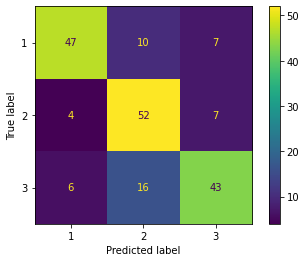


#### results for lowest loss model ####
Accuracy of: 0.75


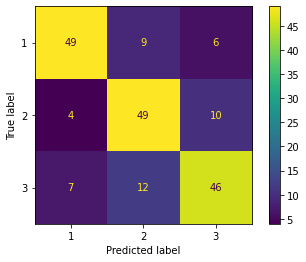


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9948 @ epoch 958
Best training loss (min) 0.1179 @ epoch 958

Best validation accuracy (max) 0.8958 @ epoch 920
Best validation loss (min) 0.3792 @ epoch 664

#### results for highest accuracy model ####
Accuracy of: 0.8594


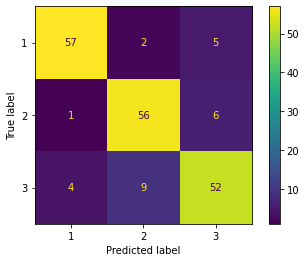


#### results for lowest loss model ####
Accuracy of: 0.8802


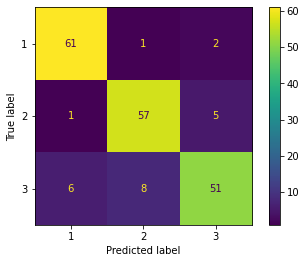


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.993 @ epoch 913
Best training loss (min) 0.1098 @ epoch 929

Best validation accuracy (max) 0.9058 @ epoch 81
Best validation loss (min) 0.3552 @ epoch 273

#### results for highest accuracy model ####
Accuracy of: 0.8115


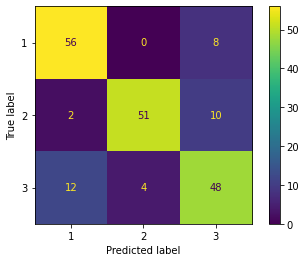


#### results for lowest loss model ####
Accuracy of: 0.8272


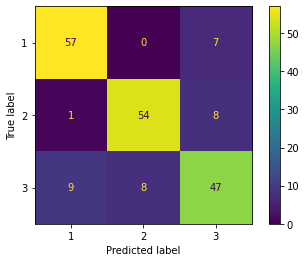

In [7]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, same session: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 500 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from ShallowConvNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with 1D conv LSTM:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.8177 @ epoch 448                             | 0.5194 @ epoch 345                         | 0.7083                                                     | 0.6927                                                      |
| C           | 0.8906 @ epoch 187                             | 0.3887 @ epoch 44                          | 0.8854                                                     | 0.8854                                                      |
| E           | 0.9215 @ epoch 339                             | 0.2673 @ epoch 443                         | 0.8429                                                     | 0.8639                                                      |


Again, for the most part results seems comparable although the result for subject B is considerably lower then EEGNet.
The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/samesubject_samesession/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, new session: EEGNet bidirectional LSTM

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 2500 epochs due to the increased amount of data, saving the best model based on best validation accuracy and validation loss (0.3 validation split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

EEGNet

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6458 @ epoch 177                             | 0.8297 @ epoch 147                         | 0.6302                                                     | 0.6188                                                      |
| C           | 0.8681 @ epoch 947                             | 0.4117 @ epoch 782                         | 0.6726                                                     | 0.6851                                                      |
| E           | 0.7361 @ epoch 166                             | 0.6617 @ epoch 75                          | 0.6513                                                     | 0.6702                                                      |

Again, no real increase nor decrease in performance is made with the LSTM extension

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_lstm/samesubject_newsession/Accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_newsession/Loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## Same subject, new session: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 500 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

EEGNet

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6545 @ epoch 300                             | 0.8255 @ epoch 169                         | 0.6385                                                     | 0.6594                                                      |
| C           | 0.8663 @ epoch 300                             | 0.4087 @ epoch 337                         | 0.6872                                                     | 0.6632                                                      |
| E           | 0.7431 @ epoch 191                             | 0.6214 @ epoch 191                         | 0.6492                                                     | 0.6492                                                      |

Model performance with the LSTM extension seems to be worse

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/samesubject_newsession/Accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/samesubject_newsession/Loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## New subject: EEGNet bidirectional LSTM

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
Perhaps the hardest task is training a classifier on data from one or more subjects, but using it to classify data from a completely new user.
This is the hardest task we'll discuss.
This section will train the same classifiers for the same participants as before but by using one participant for testing and the other two for training.

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use one participant's data for testing and the other two participant's data for training
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen subject not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 1000 epochs due to the increased training time compared to EEGNet and the fast convergence, knowing it would overfit pretty quickly, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set


In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                    
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all training data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_newsubject_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del train_subjects
                del train_subject
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.7648 @ epoch 128                        | 0.6107 @ epoch 175                    | 0.6635                                                | 0.6552                                                 |
| C           | 0.7486 @ epoch 6                          | 0.7044 @ epoch 157                    | 0.5985                                                | 0.5746                                                 |
| E           | 0.7182 @ epoch 72                         | 0.7053 @ epoch 80                     | 0.6461                                                | 0.6534                                                 |

Test set performance seems slightly better compared to EEGNet, although not by any statistical means.

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_lstm/newsubject/accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/newsubject/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## New subject: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
Perhaps the hardest task is training a classifier on data from one or more subjects, but using it to classify data from a completely new user.
This is the hardest task we'll discuss.
This section will train the same classifiers for the same participants as before but by using one participant for testing and the other two for training.

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use one participant's data for testing and the other two participant's data for training
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen subject not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 300 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set


In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                    
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all training data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_newsubject_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 300, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del train_subjects
                del train_subject
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

EEGNet with biderectional LSTM conv:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.7497 @ epoch 82                              | 0.6353 @ epoch 47                          | 0.626                                                      | 0.6125                                                      |
| C           | 0.7329 @ epoch 50                              | 0.6575 @ epoch 109                         | 0.6204                                                     | 0.5746                                                      |
| E           | 0.724 @ epoch 240                              | 0.6687 @ epoch 75                          | 0.6136                                                     | 0.6618                                                      |

Test set performance seems slightly better compared to EEGNet, although not by any statistical means.

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/newsubject/accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/newsubject/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset